# USE CASE: Etude du problème d'attrition d'une banque de détail

## Objectif de cette étude: 
-	Effectuer les analyses statistiques qui s’imposent 
-	Réaliser un modèle de scoring permettant d’identifier les clients churners
-	Donner des éléments permettant d’expliquer et de comprendre les prédictions du modèle

## Contexte: 

-	L’objectif est de produire un système permettant de générer un score de churn afin de fournir aux conseillers une liste de clients à traiter en priorité. 
-	Les conseillers bancaires, lorsqu’ils reçoivent un client à traiter souhaiterait également comprendre les raisons qui l’amène à quitter la banque afin d’adapter leur discours commercial
-	La banque est divisée en 6 branches, dont les processus de traitement de clients et les approches commerciales peuvent varier.

### Bibliothèques Python utilisées 

In [11]:
import pandas as pd 
import matplotlib.pyplot as plt
import random
import numpy as np

import seaborn as sn

from IPython.display import Markdown, display

# sklearn modules for data preprocessing:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

#sklearn modules for Model Evaluation & Improvement:
    
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.metrics import f1_score, precision_score, recall_score, fbeta_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import make_scorer, recall_score, log_loss
from sklearn.metrics import average_precision_score

#sklearn modules for Model Selection:
from sklearn import svm, tree, linear_model, neighbors
from sklearn import naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

### Importation des données

In [12]:
dataset = pd.read_csv('dataset.csv', sep=";", index_col=0)
dataset.sort_values(by='id_client', ascending=True, inplace=True)
dataset.head()

,genre,espace_client_web,assurance_vie,banque_principale,anciennete_mois,compte_epargne,credit_autres,cartes_bancaires,compte_courant,compte_joint,...,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,branche,churn
id_client,,,,,,,,,,,,,,,,,,,,,
0,F,0.0,oui,non,1.0,non,bail,basic,non,oui,...,13216.762683,13859.206348,14679.466563,13231.780818,9072.502501,14730.850501,12920.861540,18742.551182,CENTRE,non
1,H,0.0,non,non,34.0,oui,permanent,basic,oui,non,...,8449.275069,15565.521380,13227.847825,19622.902605,16384.195278,19191.523166,19569.901065,27659.692989,NORD-OUEST,non
2,H,0.0,non,non,2.0,oui,permanent,basic,oui,NaN,...,16206.280478,19034.429135,23235.482709,22215.732325,24669.049563,26697.532271,32391.470014,26714.148725,SUD-OUEST,oui
3,H,0.0,non,non,45.0,non,bail,basic,oui,non,...,NaN,17632.635995,15620.487281,20787.992352,17710.886386,20745.284745,NaN,22871.768205,SUD-EST,non
4,F,0.0,non,non,2.0,oui,permanent,medium,non,non,...,11527.410647,9523.672653,8535.781042,13901.204569,13607.338517,15628.137128,17286.251614,18611.461589,SUD-OUEST,oui


In [13]:
dataset.columns

Index(['genre', 'espace_client_web', 'assurance_vie', 'banque_principale',
       'anciennete_mois', 'compte_epargne', 'credit_autres',
       'cartes_bancaires', 'compte_courant', 'compte_joint', 'PEA',
       'assurance_auto', 'assurance_habitation', 'credit_immo', 'type',
       'compte_titres', 'methode_contact', 'agios_6mois',
       'interet_compte_epargne_total', 'age', 'segment_client', 'var_0',
       'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7', 'var_8',
       'var_9', 'var_10', 'var_11', 'var_12', 'var_13', 'var_14', 'var_15',
       'var_16', 'var_17', 'var_18', 'var_19', 'var_20', 'var_21', 'var_22',
       'var_23', 'var_24', 'var_25', 'var_26', 'var_27', 'var_28', 'var_29',
       'var_30', 'var_31', 'var_32', 'var_33', 'var_34', 'var_35', 'var_36',
       'var_37', 'var_38', 'branche', 'churn'],
      dtype='object')

In [53]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6631 entries, 0 to 7042
Data columns (total 81 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   genre                         6631 non-null   int64  
 1   espace_client_web             6631 non-null   float64
 2   assurance_vie                 6631 non-null   int64  
 3   banque_principale             6631 non-null   int64  
 4   anciennete_mois               6631 non-null   float64
 5   compte_epargne                6631 non-null   int64  
 6   credit_autres                 6631 non-null   int64  
 7   cartes_bancaires              6631 non-null   int64  
 8   compte_courant                6631 non-null   int64  
 9   compte_joint                  6631 non-null   int64  
 10  PEA                           6631 non-null   int64  
 11  assurance_auto                6631 non-null   int64  
 12  assurance_habitation          6631 non-null   int64  
 13  cre

In [15]:
dataset.describe()

,espace_client_web,anciennete_mois,agios_6mois,age,var_0,var_1,var_2,var_3,var_4,var_5,...,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38
count,6916.000000,6909.000000,6896.000000,6889.000000,6893.000000,6905.000000,6885.000000,6896.000000,6905.000000,6901.000000,...,6899.000000,6887.000000,6891.000000,6896.000000,6909.000000,6901.000000,6912.000000,6908.000000,6895.000000,6888.000000
mean,0.162666,32.378926,64.761615,43.608506,7179.987046,9181.184842,11216.801336,13181.565491,15226.615127,17203.245908,...,9785.838628,11068.392722,12451.917950,13847.487586,15330.769094,16951.694375,18658.079824,20385.900574,22273.316999,24236.491341
std,0.369088,24.572971,30.101904,16.215077,5810.200728,6146.097003,6473.621085,6755.778274,7027.169215,7292.260550,...,5557.064049,6048.259593,6548.008325,7052.226589,7588.094743,8077.431652,8687.004053,9186.926461,9830.595029,10422.086601
min,0.000000,0.000000,18.250000,20.000000,0.767658,-4241.785944,-3519.347763,-3913.768064,-5409.713059,-3465.351758,...,-11.430930,31.496118,51.786562,258.614091,474.166678,1050.553067,1401.075175,1704.972375,1924.631757,2703.861155
25%,0.000000,9.000000,35.500000,31.000000,2711.797553,4684.731756,6636.687807,8445.162191,10366.064325,12137.799285,...,5863.700722,6822.771605,7808.787487,8856.463378,9925.688827,11192.255014,12495.574275,13819.139453,15285.970426,16756.046193
50%,0.000000,29.000000,70.325000,40.000000,5761.948333,7932.505258,10077.513755,12216.321177,14357.736653,16323.371152,...,8795.690408,9991.322358,11349.583083,12688.437278,14165.118676,15661.366988,17348.631325,19163.547474,20858.094755,22798.226057
75%,0.000000,55.000000,89.900000,54.000000,10136.583353,12472.797039,14815.834866,16987.139371,19319.195330,21591.663391,...,12498.175513,14106.366808,15778.954065,17538.748692,19411.026782,21410.796020,23378.954041,25524.326086,27639.687915,30000.951224
max,1.000000,72.000000,118.750000,121.000000,41438.097046,46912.076512,51594.948678,54555.922640,58810.829646,61873.729354,...,63031.464743,65002.617141,70562.371244,68887.212623,72692.134039,83405.277234,80492.250287,90443.667291,86499.286501,91176.277613


In [16]:
dataset.dtypes

genre                 object
espace_client_web    float64
assurance_vie         object
banque_principale     object
anciennete_mois      float64
                      ...   
var_36               float64
var_37               float64
var_38               float64
branche               object
churn                 object
Length: 62, dtype: object

In [17]:
dataset.columns.to_series().groupby(dataset.dtypes).groups

{float64: ['espace_client_web', 'anciennete_mois', 'agios_6mois', 'age', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7', 'var_8', 'var_9', 'var_10', 'var_11', 'var_12', 'var_13', 'var_14', 'var_15', 'var_16', 'var_17', 'var_18', 'var_19', 'var_20', 'var_21', 'var_22', 'var_23', 'var_24', 'var_25', 'var_26', 'var_27', 'var_28', 'var_29', 'var_30', 'var_31', 'var_32', 'var_33', 'var_34', 'var_35', 'var_36', 'var_37', 'var_38'], object: ['genre', 'assurance_vie', 'banque_principale', 'compte_epargne', 'credit_autres', 'cartes_bancaires', 'compte_courant', 'compte_joint', 'PEA', 'assurance_auto', 'assurance_habitation', 'credit_immo', 'type', 'compte_titres', 'methode_contact', 'interet_compte_epargne_total', 'segment_client', 'branche', 'churn']}

### Observation des différentes valeurs présentes dans chaque colonne 

In [18]:
for col in dataset.columns:
    display(Markdown(f"Les valeurs uniques de la colonne **{col}** sont : {dataset[col].unique()}"))

Les valeurs uniques de la colonne **genre** sont : ['F' 'H' nan]

Les valeurs uniques de la colonne **espace_client_web** sont : [ 0.  1. nan]

Les valeurs uniques de la colonne **assurance_vie** sont : ['oui' 'non' nan]

Les valeurs uniques de la colonne **banque_principale** sont : ['non' 'oui' nan]

Les valeurs uniques de la colonne **anciennete_mois** sont : [ 1. 34.  2. 45.  8. 22. 10. 28. 62. 13. 16. 58. 49. 25. 69. 52. 71. 21.
 12. nan 30. 47. 72. 17. 27.  5. 46. 11. 70. 63. 43. 15. 60. 18. 66.  9.
  3. 31. 50. 64. 56.  7. 42. 35. 48. 29. 65. 38. 68. 32. 55. 37. 36. 41.
  6.  4. 33. 67. 23. 57. 61. 14. 20. 53. 40. 59. 24. 44. 19. 54. 51. 26.
  0. 39.]

Les valeurs uniques de la colonne **compte_epargne** sont : ['non' 'oui' nan]

Les valeurs uniques de la colonne **credit_autres** sont : ['bail' 'permanent' 'consommation' nan]

Les valeurs uniques de la colonne **cartes_bancaires** sont : ['basic' 'medium' 'premium' nan]

Les valeurs uniques de la colonne **compte_courant** sont : ['non' 'oui' 'inconnu' nan]

Les valeurs uniques de la colonne **compte_joint** sont : ['oui' 'non' nan 'inconnu']

Les valeurs uniques de la colonne **PEA** sont : ['non' 'oui' 'inconnu' nan]

Les valeurs uniques de la colonne **assurance_auto** sont : ['non' 'oui' 'inconnu' nan]

Les valeurs uniques de la colonne **assurance_habitation** sont : ['non' 'oui' nan 'inconnu']

Les valeurs uniques de la colonne **credit_immo** sont : ['non' 'oui' 'inconnu' nan]

Les valeurs uniques de la colonne **type** sont : ['pro' 'perso' nan]

Les valeurs uniques de la colonne **compte_titres** sont : ['oui' 'non' nan]

Les valeurs uniques de la colonne **methode_contact** sont : ['mail' 'courrier' 'telephone' 'sms' nan]

Les valeurs uniques de la colonne **agios_6mois** sont : [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]

Les valeurs uniques de la colonne **interet_compte_epargne_total** sont : ['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']

Les valeurs uniques de la colonne **age** sont : [ 97.  30.  26.  40.  20.  56.  87.  80.  28.  35.  33.  43.  25.  36.
  52.  38.  21.  24.  45.  82.  32.  44.  59.  41.  58.  69.  49.  23.
  34.  61.  72.  55.  89.  60.  29.  93.  nan  48.  50.  39.  27.  42.
  84.  75.  76.  54.  53.  31.  22.  51.  77.  65.  46.  81.  37.  64.
  47.  71.  73.  86.  79.  78.  57.  62.  67.  74.  63.  85.  70.  66.
  68.  94.  91.  83.  98.  92.  96. 121.  95.  90. 108.  88. 112. 107.
  99. 100. 103. 101. 104.]

Les valeurs uniques de la colonne **segment_client** sont : ['C4' 'B1' 'A2' 'A1' 'D3' 'D1' 'C3' 'C1' 'B4' 'A4' 'C2' 'A3' nan 'B2' 'B3'
 'D2']

Les valeurs uniques de la colonne **var_0** sont : [10544.54057498  6098.8386066   5564.5048745  ... 24494.10348552
  9653.77935819  6692.33300426]

Les valeurs uniques de la colonne **var_1** sont : [11840.84392116  7509.87114577 10149.2170228  ... 28208.77395214
 10963.32064312 12521.34158049]

Les valeurs uniques de la colonne **var_2** sont : [12101.25396605  9411.43513181 12132.3940807  ... 30625.00983201
 10933.49940825 19310.72014794]

Les valeurs uniques de la colonne **var_3** sont : [16138.58384687 12128.85595669 15965.7489854  ... 34090.28677803
 11315.13329545 21889.49644929]

Les valeurs uniques de la colonne **var_4** sont : [19256.14892925 12417.6870163  15532.4694874  ... 34270.95061788
 11731.91029051 25079.07545015]

Les valeurs uniques de la colonne **var_5** sont : [22711.19813804 13899.77575918 18011.84673982 ... 35469.78179941
 14231.24028586 26674.73142552]

Les valeurs uniques de la colonne **var_6** sont : [27090.22328045 17004.80958532 25140.88251687 ... 36492.39380791
 15682.8938489  32344.47736639]

Les valeurs uniques de la colonne **var_7** sont : [26271.00160665 20172.17019145 24200.10981534 ... 35915.61818159
 20199.28205753 36004.76114141]

Les valeurs uniques de la colonne **var_8** sont : [29031.46321488 23648.47902925 24708.30013525 ... 34307.04935314
 30114.01966765 37988.24963839]

Les valeurs uniques de la colonne **var_9** sont : [29517.77631599 25149.39113382 28416.23654399 ... 34810.08010851
 34109.06165683 41458.62750937]

Les valeurs uniques de la colonne **var_10** sont : [31132.29742153 27536.10595738 31940.63324065 ... 33213.2469494
 37382.25428173 47022.60017144]

Les valeurs uniques de la colonne **var_11** sont : [30341.41758676 27997.41585325 35380.41682641 ... 36066.96186766
 40161.10749083 47568.95050307]

Les valeurs uniques de la colonne **var_12** sont : [30079.87383118 30377.76100723 37303.42167644 ... 38043.03554351
 41656.76457629 49379.91916824]

Les valeurs uniques de la colonne **var_13** sont : [34618.0447732  33584.62128589 42070.02704508 ... 33360.7440428
 48099.83982266 53365.77989953]

Les valeurs uniques de la colonne **var_14** sont : [31134.68148138 38424.75023941 44395.83894436 ... 37228.17695931
 46444.96643147 58175.86417579]

Les valeurs uniques de la colonne **var_15** sont : [29277.52324609 38276.04308704            nan ... 47085.71815218
 50892.32178979 58234.99196722]

Les valeurs uniques de la colonne **var_16** sont : [32589.02057069 39632.64004688            nan ... 49620.03753516
 54233.36916602 60101.69416635]

Les valeurs uniques de la colonne **var_17** sont : [34717.22494068 40341.92173629 48733.90480659 ... 55038.271698
 55067.66806868 63003.75091434]

Les valeurs uniques de la colonne **var_18** sont : [36343.67155272 45619.17519934 47414.90011191 ... 57598.54865183
 56426.16358299 65194.77070757]

Les valeurs uniques de la colonne **var_19** sont : [39073.72719049 46131.13518024 50740.3721661  ... 62831.75799706
 57942.67318864 66861.60522869]

Les valeurs uniques de la colonne **var_20** sont : [ 1950.18202696  1635.9606438   1875.98982416 ... 10441.77155169
  3353.64647627  1384.97682157]

Les valeurs uniques de la colonne **var_21** sont : [ 4552.43496423  2044.59432417  2417.27589588 ... 12508.62312514
  4032.32485981  2765.22130447]

Les valeurs uniques de la colonne **var_22** sont : [ 3912.29058888            nan  2510.60742172 ... 12999.92649323
  2072.65969005  6114.02440301]

Les valeurs uniques de la colonne **var_23** sont : [ 3983.01898986  4145.9107448   3144.79517175 ... 16564.00920223
  2248.47930401  5871.11720134]

Les valeurs uniques de la colonne **var_24** sont : [ 5672.72239299  4414.69869041  3670.91946961 ... 15483.04514118
  3574.38341267  7240.21616654]

Les valeurs uniques de la colonne **var_25** sont : [ 7266.72785419  3489.18948227  4766.68958598 ... 14453.11151172
  3599.97142304 10095.3245103 ]

Les valeurs uniques de la colonne **var_26** sont : [10224.9772427   4457.73483234  7042.69734714 ... 17951.02317677
  4371.77058576 13937.88111979]

Les valeurs uniques de la colonne **var_27** sont : [ 8102.84036006  7802.79354578  7090.29224782 ... 15092.3814499
  7553.79137014 13043.27729861]

Les valeurs uniques de la colonne **var_28** sont : [13049.60414184  8647.95310783  7589.64150269 ... 16841.86112829
 13182.81525385 18854.22255998]

Les valeurs uniques de la colonne **var_29** sont : [11972.55916952  9628.05011406 10142.8821615  ... 18073.34399283
 16859.95532592 21726.15453908]

Les valeurs uniques de la colonne **var_30** sont : [13506.97814375 12738.0922617  14111.52285347 ... 12381.6360833
 18128.4605295  26458.3072071 ]

Les valeurs uniques de la colonne **var_31** sont : [13216.76268322  8449.27506924 16206.28047818 ... 16122.01008703
 18556.67119561 24256.16585144]

Les valeurs uniques de la colonne **var_32** sont : [13859.20634796 15565.52137991 19034.42913464 ... 12714.17173952
 22687.53212754 29454.09094376]

Les valeurs uniques de la colonne **var_33** sont : [14679.46656261 13227.84782464 23235.48270919 ... 24407.43273767
 28177.10356875 33741.73736944]

Les valeurs uniques de la colonne **var_34** sont : [13231.78081775 19622.90260509 22215.73232528 ... 25146.7039782
 25925.11205085 37080.82742416]

Les valeurs uniques de la colonne **var_35** sont : [ 9072.50250072 16384.19527798 24669.04956348 ... 27860.32964639
 32454.2905494  43478.18978612]

Les valeurs uniques de la colonne **var_36** sont : [14730.85050083 19191.52316605 26697.53227075 ... 27570.55858246
 32157.3078846  46567.32738854]

Les valeurs uniques de la colonne **var_37** sont : [12920.86154049 19569.90106491 32391.47001389 ... 33447.96637921
 35705.85876391 47669.72727365]

Les valeurs uniques de la colonne **var_38** sont : [18742.55118217 27659.69298873 26714.14872468 ... 40442.93164405
 35014.33969767 49881.20559997]

Les valeurs uniques de la colonne **branche** sont : ['CENTRE' 'NORD-OUEST' 'SUD-OUEST' 'SUD-EST' 'OUTRE-MER' 'NORD-EST' nan]

Les valeurs uniques de la colonne **churn** sont : ['non' 'oui']

In [19]:
#liste des colonnes 
list_col = ['genre','espace_client_web','assurance_vie','banque_principale',
            'compte_epargne','credit_autres','cartes_bancaires','compte_courant',
            'compte_joint','PEA','assurance_auto','assurance_habitation','credit_immo','type',
            'compte_titres','methode_contact','branche']

### Observation des valeurs absentes dans le jeu de données

In [20]:
missing_values_col = dataset.isna().sum()
print("Nombre de valeurs NaN par colonne :\n", missing_values_col)

Nombre de valeurs NaN par colonne :
 genre                128
espace_client_web    127
assurance_vie        131
banque_principale    122
anciennete_mois      134
                    ... 
var_36               135
var_37               148
var_38               155
branche              129
churn                  0
Length: 62, dtype: int64


In [21]:
missing_values_row = dataset.isna().sum(axis=1)
print("Nombre de valeurs NaN pour chaque ligne :\n", missing_values_row)

Nombre de valeurs NaN pour chaque ligne :
 id_client
0       0
1       1
2       3
3       2
4       2
       ..
7038    1
7039    0
7040    2
7041    1
7042    1
Length: 7043, dtype: int64


In [22]:
# Il faut remplacer toutes les valeurs absentes: 
# Création de sous listes: 

list_A = ['assurance_vie', 'banque_principale', 'compte_epargne', 'compte_titres', 'churn']

list_B = ['compte_courant', 'compte_joint', 'PEA', 'assurance_auto', 'assurance_habitation', 'credit_immo']

list_C = ['age', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7', 'var_8', 'var_9', 
          'var_10', 'var_11', 'var_12', 'var_13', 'var_14', 'var_15', 'var_16','var_17', 'var_18', 'var_19', 
          'var_20', 'var_21', 'var_22', 'var_23', 'var_24', 'var_25', 'var_26', 'var_27', 'var_28', 'var_29', 
          'var_30', 'var_31', 'var_32', 'var_33', 'var_34', 'var_35', 'var_36','var_37', 'var_38']

list_D = ['anciennete_mois', 'agios_6mois']

In [23]:
# Traitement de la colonne interet_compte_epargne_total
dataset['interet_compte_epargne_total'] = pd.to_numeric(dataset['interet_compte_epargne_total'], errors='coerce')


# Remplacement des valeurs manquantes par une valeur choisi aléatoirement en respectant la répartition. 
# Genre => repartition 50/50. 
dataset['genre'].fillna(random.choice(['F', 'H']), inplace=True)
# Espace client web => repartition 0: 83%, 1: 17%.
dataset['espace_client_web'] = dataset['espace_client_web'].apply(lambda x: np.random.choice([0,1], p=[0.83,0.17]) if pd.isna(x) else x)
# Assurance vie => repartition oui: 48%, non: 52%.
dataset['assurance_vie'] = dataset['assurance_vie'].apply(lambda x: np.random.choice(['oui','non'], p=[0.48,0.52]) if pd.isna(x) else x)
# Banque principal => repartition non: 70%, oui: 30%.
dataset['banque_principale'] = dataset['banque_principale'].apply(lambda x: np.random.choice(['non','oui'], p=[0.73,0.27]) if pd.isna(x) else x)
# Compte_epargne => repartition oui: 90%, non: 10%.
dataset['compte_epargne'] = dataset['compte_epargne'].apply(lambda x: np.random.choice(['oui','non'], p=[0.9,0.1]) if pd.isna(x) else x)
# Compte_titres => repartition oui: 60%, non: 40%.
dataset['compte_titres'] = dataset['compte_titres'].apply(lambda x: np.random.choice(['oui','non'], p=[0.6,0.4]) if pd.isna(x) else x)
# Type => repartition pro: 73%, perso: 27%.
dataset['type'] = dataset['type'].apply(lambda x: np.random.choice(['pro','perso'], p=[0.73,0.27]) if pd.isna(x) else x)

# Credit_autres => repartition perma: 48%, conso: 42%, bail: 10%.
dataset['credit_autres'] = dataset['credit_autres'].apply(lambda x: np.random.choice(['permanent','consommation','bail'], 
    p=[0.48,0.42,0.10]) if pd.isna(x) else x)
# Cartes_bancaires => repartition medium: 44%, basic: 34%, premium: 22%
dataset['cartes_bancaires'] = dataset['cartes_bancaires'].apply(lambda x: np.random.choice(['medium','basic','premium'], 
    p=[0.44,0.34,0.22]) if pd.isna(x) else x)
# methode_contact => repartition mail: 34%, courrier: 23%, telephone: 22%, sms: 21%
dataset['methode_contact'] = dataset['methode_contact'].apply(lambda x: np.random.choice(['mail','courrier','telephone','sms'], 
    p=[0.34,0.23,0.22,0.21]) if pd.isna(x) else x)

for col in list_B:
    dataset[col].fillna('inconnu', inplace=True)

# Pour les données numériques, il suffit de remplacer les valeurs manquantes par la moyenne.
for i in list_C:
    mean = dataset[i].mean()
    dataset[i].fillna(mean, inplace=True)

In [24]:
dataset.dropna(subset=['anciennete_mois', 'agios_6mois', 'interet_compte_epargne_total'], inplace=True)

In [47]:
dataset.to_csv('datasheetNoNan.csv', index=True)

### Bilan 
Le dataset contient 7043 clients différents et 60 variables. 
Parmis ces variables, il y a des données manquantes, cependant hormis dans la colonne "type" aucune colonne ne contient un grand nombre de données manquantes. 
Pour les individus de même, le nombre de données manquantes reste faible. 

Dans le cas de données binaire il est important de remplacer les valeurs manquantes par une des deux valeurs. 

Pour cela, je choisis d'attribuer aléatoirement une valeur en suivant la répartition observée avec les données présentes. 

Dans le cas de données numérique, je choisi de remplacer les valeurs manquantes par la moyenne des autres valeurs. 

Dans le cas de données catégorique, je choisi de remplacer les valeurs manquantes par une catégorie prise aléatoirement selon les proportions étudiées.

### Traitement des données

Pour toutes les variables non numérique, je les convertis
Ainsi, pour les colonnes :
- **genre**: variable binaire **H** &rarr; 0 et **F** &rarr; 1.
- **assurance_vie**: variable binaire **oui** &rarr; 0 ou **non** &rarr; 1.
- **banque_principale**: variable binaire **oui** &rarr; 0 ou **non** &rarr; 1.
- **compte_epargne**: variable binaire **oui** &rarr; 0 ou **non** &rarr; 1.
- **type**: variable binaire **pro** &rarr; 0 ou **perso** &rarr; 1.
- **compte_titres** variable binaire **oui** &rarr; 0 ou **non** &rarr; 1.

Pour les variables ternaires:
- **credit_autres**: variable ternaire  **bail** &rarr; 1, **permanent** &rarr; 2, **consommation** &rarr; 3.
- **cartes_bancaires**: variable ternaire **basic** &rarr; 1, **medium** &rarr; 2, **premium** &rarr; 3.

Pour les variables binaires + inconnu:
- **compte_courant**
- **compte_joint**
- **PEA**
- **assurance_auto**
- **assurance_habitation**
- **credit_immo** 

    Pour ces variables, les valeurs absentes seront remplacées par la valeur inconnu 
    
    La valeur **inconnu** prendra la valeur &rarr; -1.
    
    La valeur **oui** prendra la valeur &rarr; 0.
    
    La valeur **non** prendra la valeur &rarr; 1.
    
Pour la variable à estimer: 
- **churn** variable binaire **oui** &rarr; 0 ou **non** &rarr; 1.

In [25]:
for col in dataset.columns:
    # Get value count for each unique value in the column
    value_counts = dataset[col].value_counts(normalize=True)
    # Convert the value counts to percentages
    value_counts = value_counts * 100
    # Print the column name and percentage of each unique value
    display(Markdown(f"For column **{col}**:"))
    print(value_counts)

For column **genre**:

F    50.369477
H    49.630523
Name: genre, dtype: float64


For column **espace_client_web**:

0.0    83.697783
1.0    16.302217
Name: espace_client_web, dtype: float64


For column **assurance_vie**:

non    51.937868
oui    48.062132
Name: assurance_vie, dtype: float64


For column **banque_principale**:

non    70.245815
oui    29.754185
Name: banque_principale, dtype: float64


For column **anciennete_mois**:

1.0     8.641231
72.0    5.232997
2.0     3.362992
3.0     2.880410
4.0     2.563716
          ...   
59.0    0.859599
28.0    0.829437
39.0    0.829437
44.0    0.723873
36.0    0.678631
Name: anciennete_mois, Length: 72, dtype: float64


For column **compte_epargne**:

oui    90.378525
non     9.621475
Name: compte_epargne, dtype: float64


For column **credit_autres**:

permanent       48.363746
consommation    41.954456
bail             9.681798
Name: credit_autres, dtype: float64


For column **cartes_bancaires**:

medium     44.020510
basic      34.504600
premium    21.474891
Name: cartes_bancaires, dtype: float64


For column **compte_courant**:

non        48.725682
oui        28.034987
inconnu    23.239330
Name: compte_courant, dtype: float64


For column **compte_joint**:

non        42.874378
oui        34.082341
inconnu    23.043282
Name: compte_joint, dtype: float64


For column **PEA**:

non        43.040265
oui        33.780727
inconnu    23.179008
Name: PEA, dtype: float64


For column **assurance_auto**:

non        48.243101
oui        28.517569
inconnu    23.239330
Name: assurance_auto, dtype: float64


For column **assurance_habitation**:

non        39.058965
oui        37.731865
inconnu    23.209169
Name: assurance_habitation, dtype: float64


For column **credit_immo**:

non        38.651787
oui        38.078721
inconnu    23.269492
Name: credit_immo, dtype: float64


For column **type**:

pro      73.246871
perso    26.753129
Name: type, dtype: float64


For column **compte_titres**:

oui    59.101191
non    40.898809
Name: compte_titres, dtype: float64


For column **methode_contact**:

mail         33.614839
courrier     23.043282
sms          21.716182
telephone    21.625697
Name: methode_contact, dtype: float64


For column **agios_6mois**:

20.05    0.874680
19.90    0.648469
19.95    0.633389
19.85    0.633389
19.65    0.618308
           ...   
57.45    0.015081
53.90    0.015081
92.10    0.015081
23.65    0.015081
78.70    0.015081
Name: agios_6mois, Length: 1561, dtype: float64


For column **interet_compte_epargne_total**:

20.20      0.165887
19.75      0.135726
19.65      0.120645
20.05      0.120645
19.55      0.105565
             ...   
692.35     0.015081
130.15     0.015081
3211.90    0.015081
7843.55    0.015081
6844.50    0.015081
Name: interet_compte_epargne_total, Length: 6181, dtype: float64


For column **age**:

38.0     3.287589
39.0     3.272508
36.0     2.759765
35.0     2.729603
37.0     2.714523
           ...   
107.0    0.015081
100.0    0.015081
103.0    0.015081
101.0    0.015081
104.0    0.015081
Name: age, Length: 89, dtype: float64


For column **segment_client**:

D1    10.442696
B2    10.396421
A1    10.319297
C1    10.319297
B1     9.979948
C4     9.763998
C2     9.548049
A4     9.440074
C3     9.208700
B4     1.835570
D2     1.773870
D3     1.758445
A3     1.743020
B3     1.743020
A2     1.727595
Name: segment_client, dtype: float64


For column **var_0**:

7179.987046     2.111295
10544.540575    0.015081
5134.292528     0.015081
2462.843692     0.015081
175.712756      0.015081
                  ...   
4361.106447     0.015081
9116.684370     0.015081
11096.222342    0.015081
9448.278045     0.015081
6692.333004     0.015081
Name: var_0, Length: 6492, dtype: float64


For column **var_1**:

9181.184842     1.915247
11840.843921    0.015081
5418.295102     0.015081
3036.505748     0.015081
11186.575761    0.015081
                  ...   
16664.898295    0.015081
5441.281608     0.015081
9057.007272     0.015081
11692.516369    0.015081
12521.341580    0.015081
Name: var_1, Length: 6505, dtype: float64


For column **var_2**:

11216.801336    2.186699
12101.253966    0.015081
7495.684856     0.015081
14859.405444    0.015081
7560.826275     0.015081
                  ...   
3960.786953     0.015081
7684.432854     0.015081
1711.226387     0.015081
24970.177883    0.015081
19310.720148    0.015081
Name: var_2, Length: 6487, dtype: float64


For column **var_3**:

13181.565491    2.096215
16138.583847    0.015081
28069.772598    0.015081
16783.412854    0.015081
10581.358269    0.015081
                  ...   
8477.038200     0.015081
10707.987847    0.015081
21759.035909    0.015081
5871.523947     0.015081
21889.496449    0.015081
Name: var_3, Length: 6493, dtype: float64


For column **var_4**:

15226.615127    1.885085
19256.148929    0.015081
14621.411201    0.015081
19782.442504    0.015081
10420.954323    0.015081
                  ...   
3600.493178     0.015081
11822.980123    0.015081
1028.578862     0.015081
33159.790044    0.015081
25079.075450    0.015081
Name: var_4, Length: 6507, dtype: float64


For column **var_5**:

17203.245908    2.066053
22711.198138    0.015081
7222.828206     0.015081
15036.999450    0.015081
27655.998846    0.015081
                  ...   
14162.055507    0.015081
15309.314003    0.015081
23265.387886    0.015081
13082.768862    0.015081
26674.731426    0.015081
Name: var_5, Length: 6495, dtype: float64


For column **var_6**:

19153.174193    1.749359
27090.223280    0.015081
19748.835976    0.015081
30807.322193    0.015081
13331.190734    0.015081
                  ...   
14860.141464    0.015081
26546.731905    0.015081
23011.698064    0.015081
7351.162178     0.015081
32344.477366    0.015081
Name: var_6, Length: 6516, dtype: float64


For column **var_7**:

21140.626041    1.960489
26271.001607    0.015081
11579.252719    0.015081
24545.861463    0.015081
22107.278601    0.015081
                  ...   
27119.681134    0.015081
12288.163121    0.015081
20557.831714    0.015081
8977.196116     0.015081
36004.761141    0.015081
Name: var_7, Length: 6502, dtype: float64


For column **var_8**:

23168.689721    1.794601
29031.463215    0.015081
36486.889332    0.015081
21592.147694    0.015081
16478.638541    0.015081
                  ...   
33558.111536    0.015081
20124.175929    0.015081
44401.330226    0.015081
22076.076727    0.015081
37988.249638    0.015081
Name: var_8, Length: 6513, dtype: float64


For column **var_9**:

25129.685065    1.960489
29517.776316    0.015081
14156.612453    0.015081
43889.074010    0.015081
18697.801221    0.015081
                  ...   
24723.117602    0.015081
32829.290268    0.015081
20274.721776    0.015081
48157.599998    0.015081
41458.627509    0.015081
Name: var_9, Length: 6502, dtype: float64


For column **var_10**:

27152.790413    1.900166
31132.297422    0.015081
17720.225279    0.015081
22604.377552    0.015081
26423.886821    0.015081
                  ...   
29696.285380    0.015081
18287.719041    0.015081
38765.838786    0.015081
38413.273516    0.015081
47022.600171    0.015081
Name: var_10, Length: 6506, dtype: float64


For column **var_11**:

29149.664388    1.885085
30341.417587    0.015081
18969.065102    0.015081
31538.245745    0.015081
23269.824069    0.015081
                  ...   
50105.889196    0.015081
26563.539163    0.015081
16787.667878    0.015081
30725.788392    0.015081
47568.950503    0.015081
Name: var_11, Length: 6507, dtype: float64


For column **var_12**:

31131.285760    1.854924
30079.873831    0.015081
41726.367594    0.015081
29418.240501    0.015081
31321.365154    0.015081
                  ...   
43315.807688    0.015081
27226.339394    0.015081
52729.784266    0.015081
26630.222462    0.015081
49379.919168    0.015081
Name: var_12, Length: 6509, dtype: float64


For column **var_13**:

33082.709767    1.885085
27373.125731    0.015081
27066.321405    0.015081
48175.138715    0.015081
28913.974306    0.015081
                  ...   
37238.541171    0.015081
20800.224214    0.015081
49546.493223    0.015081
24842.929401    0.015081
53365.779900    0.015081
Name: var_13, Length: 6507, dtype: float64


For column **var_14**:

35116.480254    2.186699
31134.681481    0.015081
36049.401582    0.015081
27177.043964    0.015081
29622.080644    0.015081
                  ...   
40727.756385    0.015081
34393.727653    0.015081
34943.366100    0.015081
19647.353973    0.015081
58175.864176    0.015081
Name: var_14, Length: 6487, dtype: float64


For column **var_15**:

37092.498762    2.231941
29277.523246    0.015081
51663.636999    0.015081
39731.026725    0.015081
31520.798323    0.015081
                  ...   
21124.379376    0.015081
41059.346993    0.015081
19870.102678    0.015081
51164.312152    0.015081
58234.991967    0.015081
Name: var_15, Length: 6484, dtype: float64


For column **var_16**:

39062.675576    2.186699
32589.020571    0.015081
35859.873961    0.015081
32208.109200    0.015081
32895.114995    0.015081
                  ...   
42269.036240    0.015081
39780.483835    0.015081
19553.314015    0.015081
69190.137661    0.015081
60101.694166    0.015081
Name: var_16, Length: 6487, dtype: float64


For column **var_17**:

41108.330364    1.673956
34717.224941    0.015081
39923.700214    0.015081
37390.563264    0.015081
36572.045927    0.015081
                  ...   
41443.374578    0.015081
22595.636158    0.015081
54849.567774    0.015081
44309.537043    0.015081
63003.750914    0.015081
Name: var_17, Length: 6521, dtype: float64


For column **var_18**:

43137.077894    2.488312
36343.671553    0.015081
35581.455207    0.015081
41503.471447    0.015081
35447.257685    0.015081
                  ...   
65161.540768    0.015081
37849.051401    0.015081
27064.512743    0.015081
42585.333210    0.015081
65194.770708    0.015081
Name: var_18, Length: 6467, dtype: float64


For column **var_19**:

45114.458351    1.960489
39073.727190    0.015081
45084.536510    0.015081
45080.255911    0.015081
39734.513681    0.015081
                  ...   
22652.599352    0.015081
75689.520687    0.015081
52638.344939    0.015081
51389.466036    0.015081
66861.605229    0.015081
Name: var_19, Length: 6502, dtype: float64


For column **var_20**:

1831.056165    1.975569
1950.182027    0.015081
1325.467695    0.015081
616.641969     0.015081
184.266968     0.015081
                 ...   
578.862894     0.015081
691.978731     0.015081
5782.467008    0.015081
3220.719506    0.015081
1384.976822    0.015081
Name: var_20, Length: 6501, dtype: float64


For column **var_21**:

2392.217585    1.945408
4034.134483    0.015081
637.354838     0.015081
409.881258     0.015081
1995.472564    0.015081
                 ...   
3934.881000    0.015081
1202.500530    0.015081
1296.094157    0.015081
2239.455086    0.015081
2765.221304    0.015081
Name: var_21, Length: 6503, dtype: float64


For column **var_22**:

3046.721499    2.171618
6142.221364    0.015081
1617.571668    0.015081
818.107725     0.015081
3293.695317    0.015081
                 ...   
3718.046137    0.015081
2024.589982    0.015081
529.504167     0.015081
2574.333717    0.015081
6114.024403    0.015081
Name: var_22, Length: 6488, dtype: float64


For column **var_23**:

3751.171018     2.096215
3983.018990     0.015081
4074.283780     0.015081
3047.986796     0.015081
1051.425397     0.015081
                  ...   
1135.166530     0.015081
3017.088821     0.015081
363.071371      0.015081
12851.733341    0.015081
5871.117201     0.015081
Name: var_23, Length: 6493, dtype: float64


For column **var_24**:

4571.258256     2.081134
5672.722393     0.015081
2649.063981     0.015081
4217.063163     0.015081
1827.831907     0.015081
                  ...   
7213.334178     0.015081
3597.073350     0.015081
13490.255765    0.015081
4804.301846     0.015081
7240.216167     0.015081
Name: var_24, Length: 6494, dtype: float64


For column **var_25**:

5443.256338     1.945408
7266.727854     0.015081
3829.087882     0.015081
5397.878757     0.015081
1880.215073     0.015081
                  ...   
713.139953      0.015081
5464.432822     0.015081
4136.918644     0.015081
5863.090802     0.015081
10095.324510    0.015081
Name: var_25, Length: 6503, dtype: float64


For column **var_26**:

6388.922336     1.990650
10224.977243    0.015081
4998.636861     0.015081
3517.915962     0.015081
7913.277820     0.015081
                  ...   
5042.062064     0.015081
11647.174908    0.015081
4504.212651     0.015081
18444.238368    0.015081
13937.881120    0.015081
Name: var_26, Length: 6500, dtype: float64


For column **var_27**:

7466.224002     2.126376
5191.208502     0.015081
3810.508922     0.015081
15097.759898    0.015081
3890.645785     0.015081
                  ...   
14055.319811    0.015081
7453.055676     0.015081
5334.671183     0.015081
12483.342805    0.015081
13043.277299    0.015081
Name: var_27, Length: 6491, dtype: float64


For column **var_28**:

8579.794540     1.885085
13049.604142    0.015081
8135.226178     0.015081
8184.322806     0.015081
8340.651911     0.015081
                  ...   
13673.299228    0.015081
12649.408263    0.015081
4676.646408     0.015081
10371.655487    0.015081
18854.222560    0.015081
Name: var_28, Length: 6507, dtype: float64


For column **var_29**:

9785.838628     2.035892
11972.559170    0.015081
11954.715950    0.015081
9824.051198     0.015081
9065.518196     0.015081
                  ...   
12935.513397    0.015081
17369.954495    0.015081
5316.187079     0.015081
10731.586591    0.015081
21726.154539    0.015081
Name: var_29, Length: 6497, dtype: float64


For column **var_30**:

11068.392722    2.186699
13506.978144    0.015081
4160.912224     0.015081
13631.840820    0.015081
4002.371547     0.015081
                  ...   
10614.073290    0.015081
4875.684221     0.015081
21407.833370    0.015081
17956.744920    0.015081
26458.307207    0.015081
Name: var_30, Length: 6487, dtype: float64


For column **var_31**:

12451.917950    2.186699
13216.762683    0.015081
21165.321007    0.015081
7435.504391     0.015081
14935.298288    0.015081
                  ...   
12956.037868    0.015081
9625.500251     0.015081
16564.373540    0.015081
7834.922446     0.015081
24256.165851    0.015081
Name: var_31, Length: 6487, dtype: float64


For column **var_32**:

13847.487586    2.005731
13859.206348    0.015081
19943.182133    0.015081
14747.699193    0.015081
12279.265622    0.015081
                  ...   
7812.988888     0.015081
6010.841608     0.015081
12913.287084    0.015081
4699.181381     0.015081
29454.090944    0.015081
Name: var_32, Length: 6499, dtype: float64


For column **var_33**:

15330.769094    1.885085
14679.466563    0.015081
19146.348515    0.015081
9578.548998     0.015081
13387.567847    0.015081
                  ...   
14085.929900    0.015081
6826.833082     0.015081
39302.637297    0.015081
15581.660574    0.015081
33741.737369    0.015081
Name: var_33, Length: 6507, dtype: float64


For column **var_34**:

16951.694375    1.975569
9940.975915     0.015081
9305.343898     0.015081
11071.779401    0.015081
11568.775688    0.015081
                  ...   
35862.664709    0.015081
9919.073248     0.015081
6999.004187     0.015081
18614.373543    0.015081
37080.827424    0.015081
Name: var_34, Length: 6501, dtype: float64


For column **var_35**:

18658.079824    1.824762
9072.502501     0.015081
15417.861214    0.015081
14628.282576    0.015081
11780.831575    0.015081
                  ...   
14927.227922    0.015081
5884.905633     0.015081
44924.429144    0.015081
25407.961529    0.015081
43478.189786    0.015081
Name: var_35, Length: 6511, dtype: float64


For column **var_36**:

20385.900574    1.854924
14299.265206    0.015081
16785.651753    0.015081
19509.346426    0.015081
22234.939160    0.015081
                  ...   
5842.961262     0.015081
30001.165990    0.015081
18655.815856    0.015081
21073.685921    0.015081
46567.327389    0.015081
Name: var_36, Length: 6509, dtype: float64


For column **var_37**:

22273.316999    2.096215
12920.861540    0.015081
17353.724110    0.015081
18720.574923    0.015081
17293.829874    0.015081
                  ...   
20892.340969    0.015081
52037.529188    0.015081
14469.893856    0.015081
11131.974945    0.015081
47669.727274    0.015081
Name: var_37, Length: 6493, dtype: float64


For column **var_38**:

24236.491341    2.247022
18742.551182    0.015081
17605.850015    0.015081
35878.878114    0.015081
17134.236662    0.015081
                  ...   
9508.242202     0.015081
23093.996682    0.015081
8824.939666     0.015081
34858.592062    0.015081
49881.205600    0.015081
Name: var_38, Length: 6483, dtype: float64


For column **branche**:

NORD-EST      17.945963
OUTRE-MER     17.899908
SUD-EST       17.132330
CENTRE        17.055573
SUD-OUEST     16.840651
NORD-OUEST    13.125576
Name: branche, dtype: float64


For column **churn**:

non    73.654049
oui    26.345951
Name: churn, dtype: float64


Evaluation de la répartition des valeurs: 

Pour la variable **genre**, il y a une quasi équivalence entre hommes et femmes. 

Pour la variable **banque_principale**, il y a une différence significative entre le rapport des 2 valeurs. 

In [26]:
# Création de sous listes: 
list_A = ['assurance_vie', 'banque_principale', 'compte_epargne', 'compte_titres', 'churn']
list_B = ['compte_courant', 'compte_joint', 'PEA', 'assurance_auto', 'assurance_habitation', 'credit_immo']
list_C = ['anciennete_mois', 'agios_6mois','age', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 
          'var_7', 'var_8', 'var_9', 'var_10', 'var_11', 'var_12', 'var_13', 'var_14', 'var_15', 'var_16',
          'var_17', 'var_18', 'var_19', 'var_20', 'var_21', 'var_22', 'var_23', 'var_24', 'var_25', 'var_26', 
          'var_27', 'var_28', 'var_29', 'var_30', 'var_31', 'var_32', 'var_33', 'var_34', 'var_35', 'var_36',
          'var_37', 'var_38']

## Modification du dataset selon les règles précédentes 

In [27]:
# Modification des données en valeurs numériques:
dataset['genre'] = dataset['genre'].replace({'F': 0, 'H': 1})
dataset['type'] = dataset['type'].replace({'pro':0, 'perso':1})
dataset['credit_autres'] = dataset['credit_autres'].replace({'permanent':0, 'consommation':1, 'bail':2})
dataset['cartes_bancaires'] = dataset['cartes_bancaires'].replace({'medium':0, 'basic':1, 'premium':2})
dataset['methode_contact'] = dataset['methode_contact'].replace({'mail':0, 'courrier':1, 'telephone':2, 'sms':3})

for col in list_A:
    dataset[col] = dataset[col].replace({'oui':0, 'non':1})

for col in list_B:
    dataset[col].fillna('inconnu', inplace=True)
    dataset[col] = dataset[col].replace({'oui': 0, 'non': 1, 'inconnu':-1})

# Remplacement des valeurs manquantes par une valeur choisi aléatoirement en respectant la répartition. 
# Genre => repartition 50/50. 
dataset['genre'].fillna(random.choice([0, 1]), inplace=True)
# Espace client web => repartition 0: 83%, 1: 17%.
dataset['espace_client_web'] = dataset['espace_client_web'].apply(lambda x: np.random.choice([0,1], p=[0.83,0.17]) if pd.isna(x) else x)
# Assurance vie => repartition oui: 48%, non: 52%.
dataset['assurance_vie'] = dataset['assurance_vie'].apply(lambda x: np.random.choice([0,1], p=[0.48,0.52]) if pd.isna(x) else x)
# Banque principal => repartition non: 70%, oui: 30%.
dataset['banque_principale'] = dataset['banque_principale'].apply(lambda x: np.random.choice([0,1], p=[0.73,0.27]) if pd.isna(x) else x)
# Compte_epargne => repartition oui: 90%, non: 10%.
dataset['compte_epargne'] = dataset['compte_epargne'].apply(lambda x: np.random.choice([0,1], p=[0.9,0.1]) if pd.isna(x) else x)
# Compte_titres => repartition oui: 60%, non: 40%.
dataset['compte_titres'] = dataset['compte_titres'].apply(lambda x: np.random.choice([0,1], p=[0.6,0.4]) if pd.isna(x) else x)
# Type => repartition pro: 73%, perso: 27%.
dataset['type'] = dataset['type'].apply(lambda x: np.random.choice([0,1], p=[0.73,0.27]) if pd.isna(x) else x)

# Credit_autres => repartition perma: 48%, conso: 42%, bail: 10%.
dataset['credit_autres'] = dataset['credit_autres'].apply(lambda x: np.random.choice([0,1,2], p=[0.48,0.42,0.10]) if pd.isna(x) else x)
# Cartes_bancaires => repartition medium: 44%, basic: 34%, premium: 22%
dataset['cartes_bancaires'] = dataset['cartes_bancaires'].apply(lambda x: np.random.choice([0,1,2], p=[0.48,0.42,0.10]) if pd.isna(x) else x)
# methode_contact => repartition mail: 34%, courrier: 23%, telephone: 22%, sms: 21%
dataset['methode_contact'] = dataset['methode_contact'].apply(lambda x: np.random.choice([0,1,2,3], p=[0.34,0.23,0.22,0.21]) if pd.isna(x) else x)

# Pour les données numériques, il suffit de remplacer les valeurs manquantes par la moyenne.
for i in list_C:
    mean = dataset[i].mean()
    dataset[i].fillna(mean, inplace=True)

In [28]:
# Traitement de la colonne interet_compte_epargne_total
dataset['interet_compte_epargne_total'] = pd.to_numeric(dataset['interet_compte_epargne_total'], errors='coerce')
mean = dataset['interet_compte_epargne_total'].mean()
dataset['interet_compte_epargne_total'].fillna(mean, inplace=True)

In [29]:
# Traitement de la colonne segement_client 
# Traitement de la colonne branche 
dataset = pd.get_dummies(dataset, columns=['segment_client'])
dataset = pd.get_dummies(dataset, columns=['branche'])

# Démarche hot one pour ces variables de catégorielles.

In [30]:
dataset.to_csv('CleanDatasheet.csv', index=True)

## Visualisation des données 

In [31]:
# A partir d'ici, il n'y a pas de valeurs manquantes

# Il est possible de visualiser quelques données. 



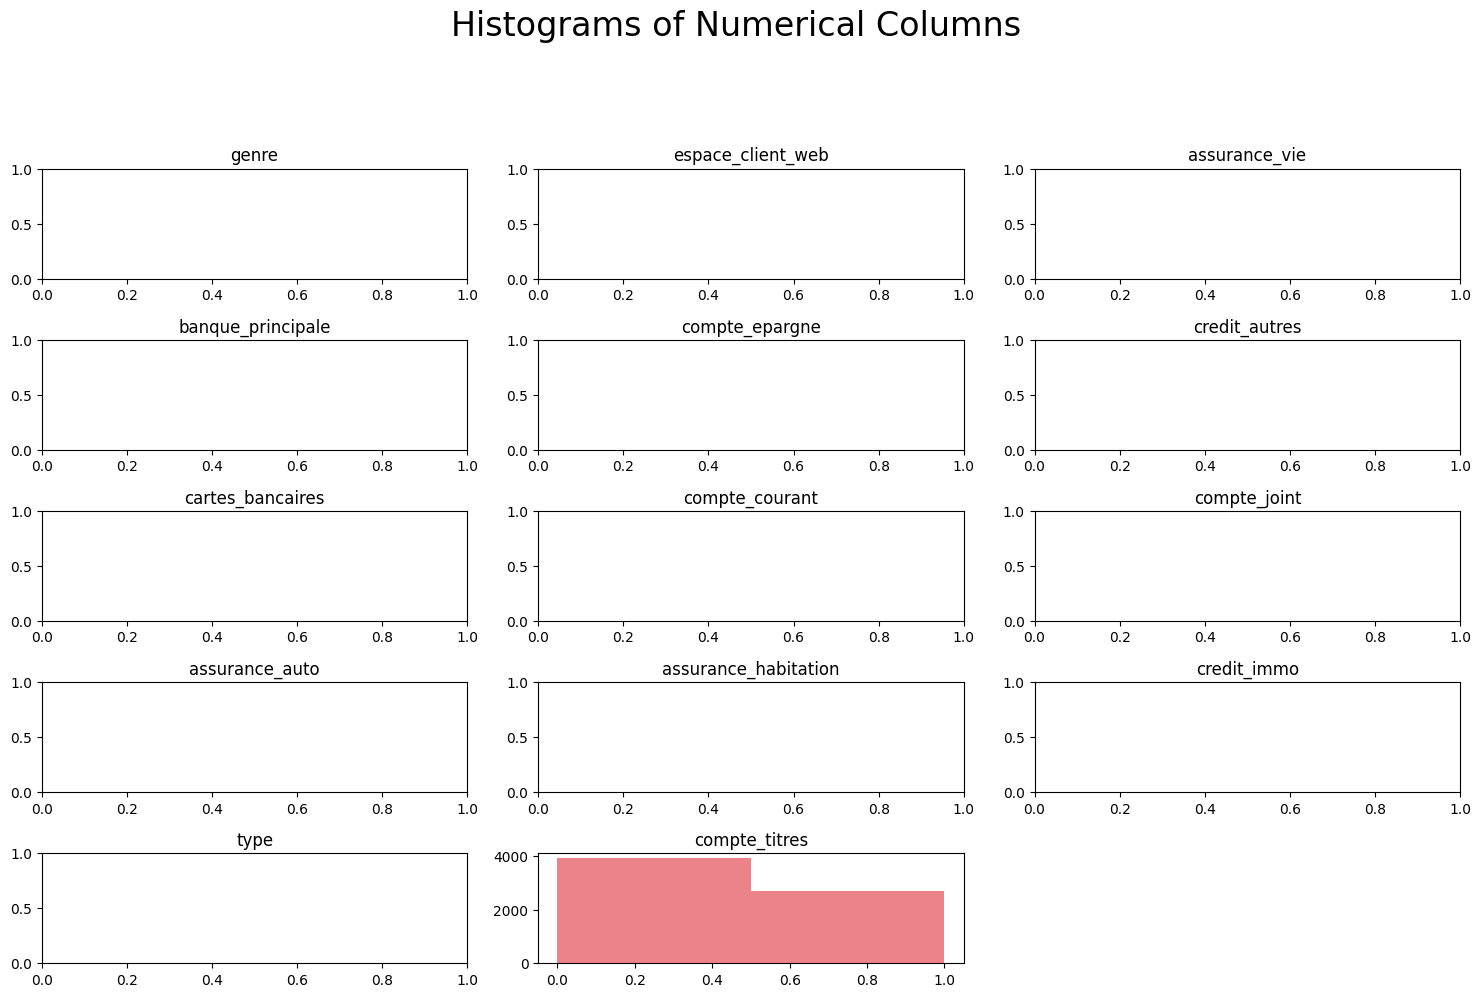

In [32]:
dataset2 = dataset[['genre','espace_client_web', 'assurance_vie', 'banque_principale', 'compte_epargne', 
                    'credit_autres', 'cartes_bancaires', 'compte_courant','compte_joint', 'assurance_auto', 
                    'assurance_habitation', 'credit_immo', 'type', 'compte_titres']]

#Histogram:
    
fig = plt.figure(figsize=(15, 12))
plt.suptitle('Histograms of Numerical Columns\n',horizontalalignment="center",fontstyle = "normal", fontsize = 24, fontfamily = "sans-serif")
for i in range(dataset2.shape[1]):
    plt.subplot(6, 3, i + 1)
    f = plt.gca()
    f.set_title(dataset2.columns.values[i])
    vals = np.size(dataset2.iloc[:, i].unique())
    if vals >= 100:
        vals = 100
    
plt.hist(dataset2.iloc[:, i], bins=vals, color = '#ec838a')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

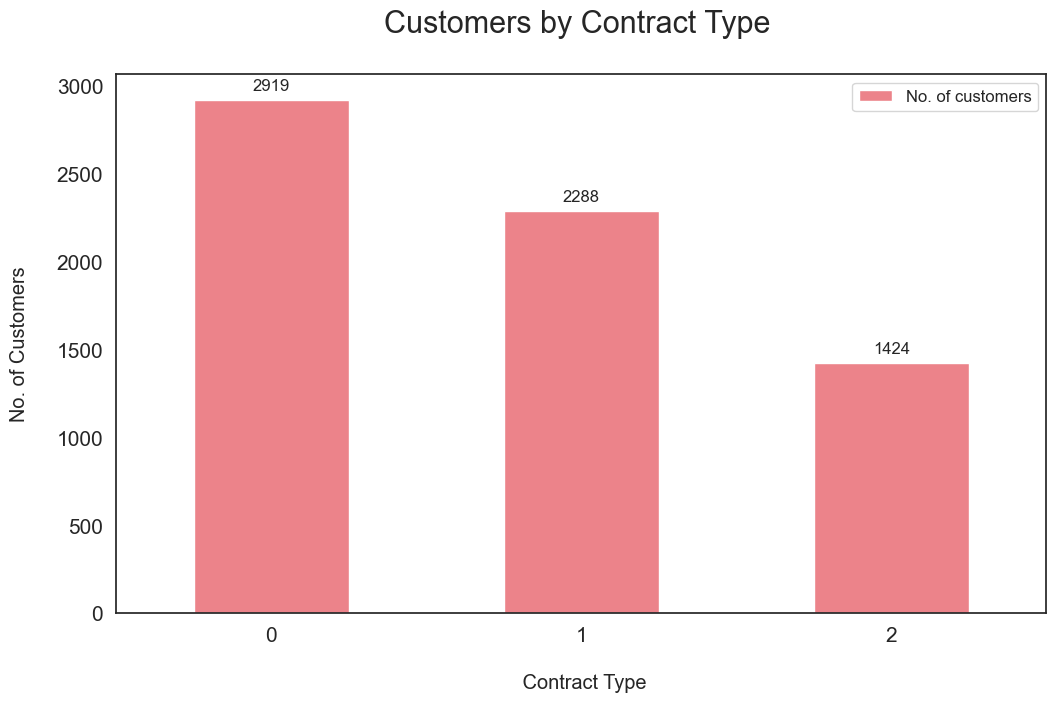

In [56]:
contract_split = dataset[[ "credit_autres", "cartes_bancaires"]]
sectors = contract_split .groupby ("cartes_bancaires")
contract_split = pd.DataFrame(sectors["credit_autres"].count())
contract_split.rename(columns={'credit_autres':'No. of customers'}, inplace=True)
ax =  contract_split[["No. of customers"]].plot.bar(title = 'Customers by Contract Type',legend =True, table = False, 
grid = False,  subplots = False,figsize =(12, 7), color ='#ec838a', 
fontsize = 15, stacked=False)
plt.ylabel('No. of Customers\n',
horizontalalignment="center",fontstyle = "normal", 
fontsize = "large", fontfamily = "sans-serif")
plt.xlabel('\n Contract Type',
horizontalalignment="center",fontstyle = "normal", 
fontsize = "large", fontfamily = "sans-serif")
plt.title('Customers by Contract Type \n',
horizontalalignment="center",fontstyle = "normal", 
fontsize = "22", fontfamily = "sans-serif")
plt.legend(loc='upper right', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
x_labels = np.array(contract_split[["No. of customers"]])
def add_value_labels(ax, spacing=5):   
    for rect in ax.patches:      
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2       
        space = spacing        
        va = 'bottom'      
        if y_value < 0:           
            space *= -1            
            va = 'top'       
        label = "{:.0f}".format(y_value)      
        ax.annotate(
            label,                      
            (x_value, y_value),         
            xytext=(0, space),          
            textcoords="offset points", 
            ha='center',                
            va=va)  
        
add_value_labels(ax)

Text(0.5, 1.0, 'Correlation with Churn Rate \n')

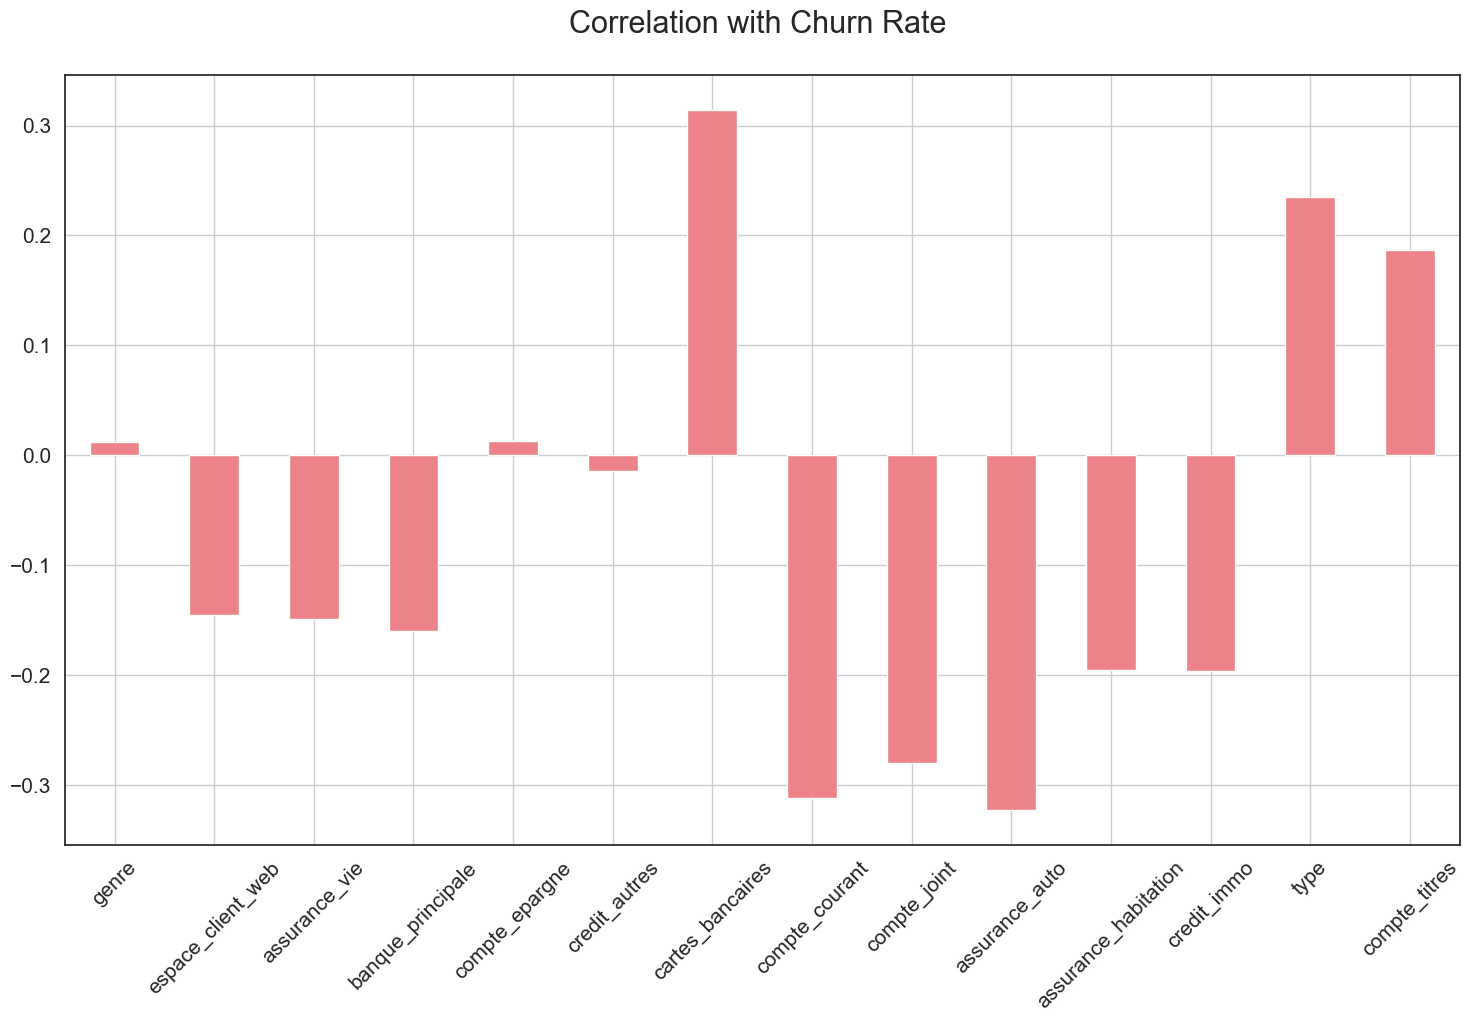

In [57]:
correlations = dataset2.corrwith(dataset.churn)
correlations = correlations[correlations!=1]
correlations.plot.bar(
        figsize = (18, 10), 
        fontsize = 15, 
        color = '#ec838a',
        rot = 45, grid = True)
plt.title('Correlation with Churn Rate \n',
horizontalalignment="center", fontstyle = "normal", 
fontsize = "22", fontfamily = "sans-serif")

/var/folders/t6/t5h5090d6mb3hs8y3fgw7s8c0000gn/T/ipykernel_1558/1681834318.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

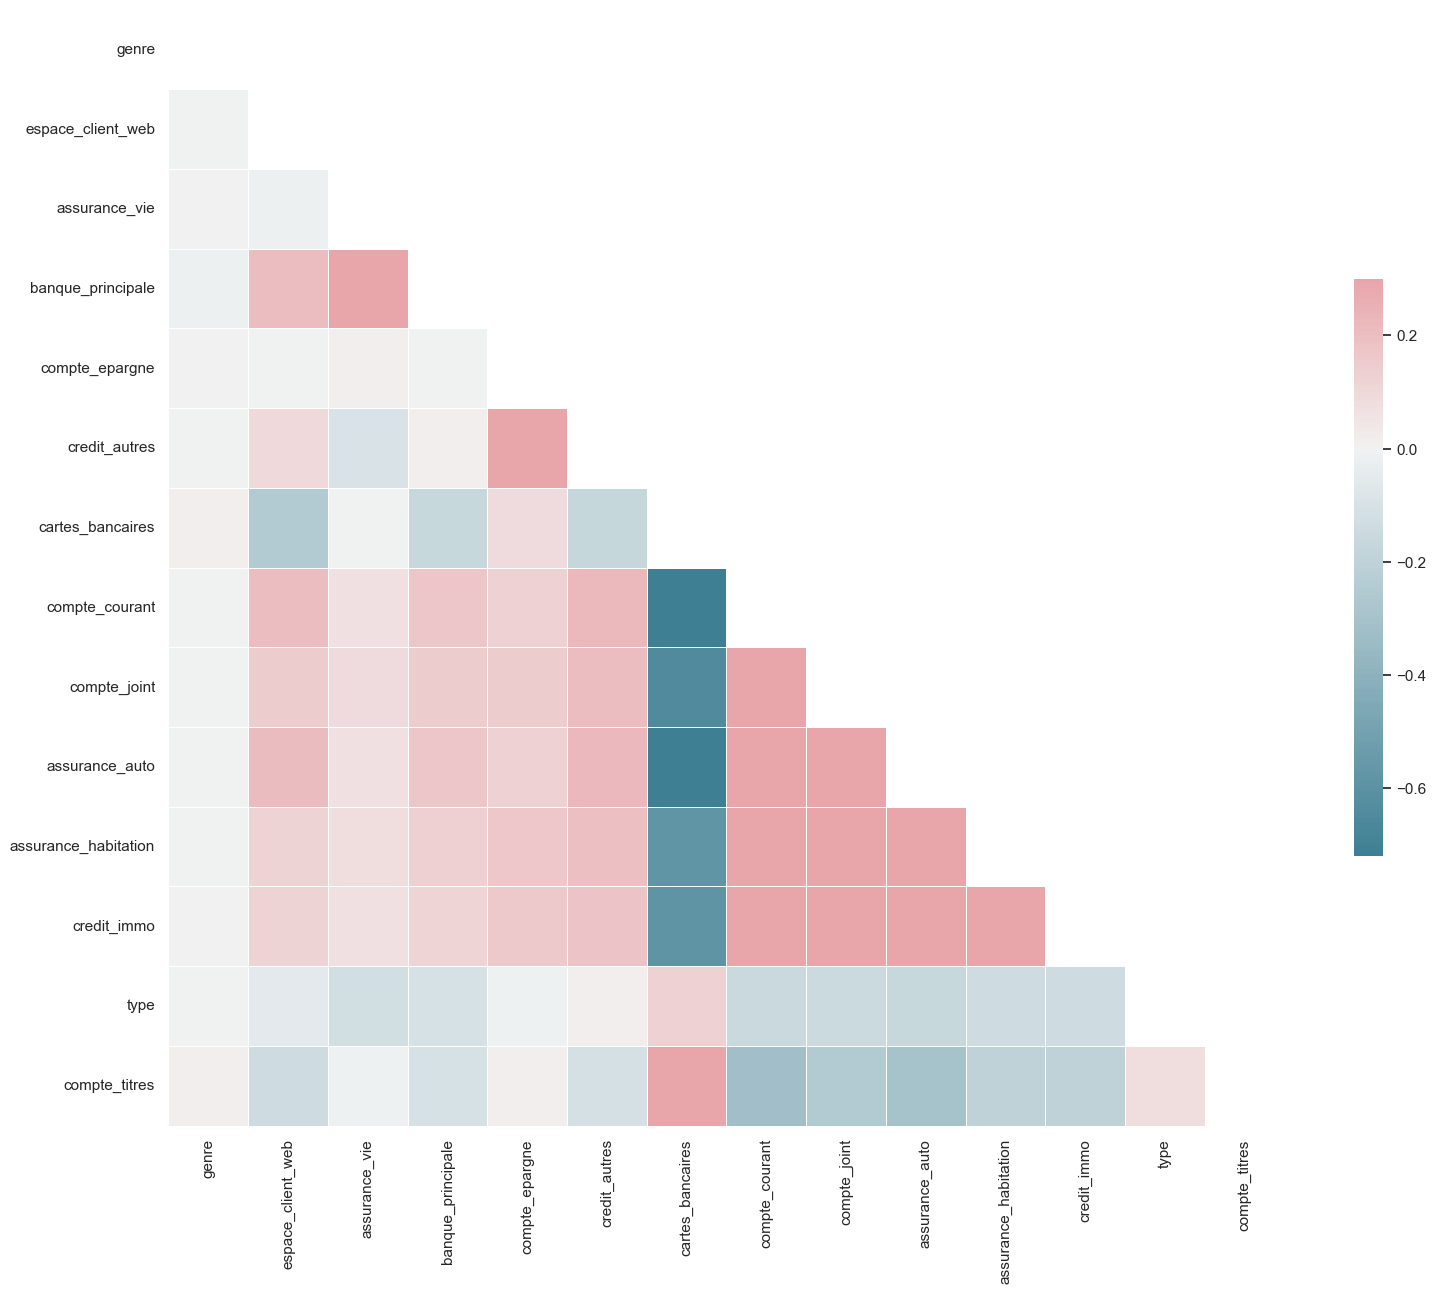

In [35]:
#Set and compute the Correlation Matrix:
sn.set(style="white")
corr = dataset2.corr()
#Generate a mask for the upper triangle:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
#Set up the matplotlib figure and a diverging colormap:
f, ax = plt.subplots(figsize=(18, 15))
cmap = sn.diverging_palette(220, 10, as_cmap=True)
#Draw the heatmap with the mask and correct aspect ratio:
sn.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [36]:
def calc_vif(X):
# Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) 
    for i in range(X.shape[1])]
    return(vif)

dataset2 = dataset[['genre','espace_client_web', 'assurance_vie', 'banque_principale', 'compte_epargne', 'credit_autres', 'cartes_bancaires', 'compte_courant','compte_joint', 'assurance_auto', 'assurance_habitation', 'credit_immo', 'type', 'compte_titres']]
calc_vif(dataset2)

,variables,VIF
0,genre,1.835826
1,espace_client_web,1.327036
2,assurance_vie,2.656608
3,banque_principale,3.869035
4,compte_epargne,2.080215
5,credit_autres,3.120070
6,cartes_bancaires,3.845650
7,compte_courant,3.191689
8,compte_joint,2.845898
9,assurance_auto,3.425339


In [37]:
# Préparation des données 

Y = dataset["churn"]
X = dataset.drop(columns="churn")

In [38]:
# Split the data into train and test sets.

X_train, X_test, y_train, y_test = train_test_split(X, Y,stratify=Y, test_size = 0.2)
#use 0.9 if data is huge.random_state = 0)
#to resolve any class imbalance - use stratify parameter.
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (5304, 80)
Number transactions y_train dataset:  (5304,)
Number transactions X_test dataset:  (1327, 80)
Number transactions y_test dataset:  (1327,)


In [39]:
sc_X = StandardScaler()
X_train2 = pd.DataFrame(sc_X.fit_transform(X_train))
X_train2.columns = X_train.columns.values
X_train2.index = X_train.index.values
X_train = X_train2
X_test2 = pd.DataFrame(sc_X.transform(X_test))
X_test2.columns = X_test.columns.values
X_test2.index = X_test.index.values
X_test = X_test2

In [40]:
models = []
models.append(('Logistic Regression', LogisticRegression(solver='liblinear', random_state = 0, class_weight='balanced')))
models.append(('SVC', SVC(kernel = 'linear', random_state = 0)))
models.append(('Kernel SVM', SVC(kernel = 'rbf', random_state = 0)))
models.append(('KNN', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)))
models.append(('Gaussian NB', GaussianNB()))
models.append(('Decision Tree Classifier', DecisionTreeClassifier(criterion = 'entropy', random_state = 0)))
models.append(('Random Forest', RandomForestClassifier(n_estimators=100, criterion = 'entropy', random_state = 0)))
#Evaluating Model Results:
acc_results = []
auc_results = []
names = []
# set table to table to populate with performance results
col = ['Algorithm', 'ROC AUC Mean', 'ROC AUC STD', 'Accuracy Mean', 'Accuracy STD']
model_results = pd.DataFrame(columns=col)
i = 0
# Evaluate each model using k-fold cross-validation:
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=None)
    # accuracy scoring:
    cv_acc_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    # roc_auc scoring:
    cv_auc_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    acc_results.append(cv_acc_results)
    auc_results.append(cv_auc_results)
    names.append(name)
    model_results.loc[i] = [name,round(cv_auc_results.mean()*100, 2),round(cv_auc_results.std()*100, 2),round(cv_acc_results.mean()*100, 2),round(cv_acc_results.std()*100, 2)]
    i += 1
    
model_results.sort_values(by=['ROC AUC Mean'], ascending=False)

,Algorithm,ROC AUC Mean,ROC AUC STD,Accuracy Mean,Accuracy STD
0,Logistic Regression,93.16,1.01,85.26,1.27
1,SVC,92.91,1.02,87.54,1.00
2,Kernel SVM,91.98,1.45,87.88,1.03
6,Random Forest,90.45,1.64,84.67,1.56
3,KNN,85.28,1.87,83.94,1.04
5,Decision Tree Classifier,70.57,1.97,77.75,1.58
4,Gaussian NB,69.57,2.28,83.99,1.41


In [78]:
# Visualisation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


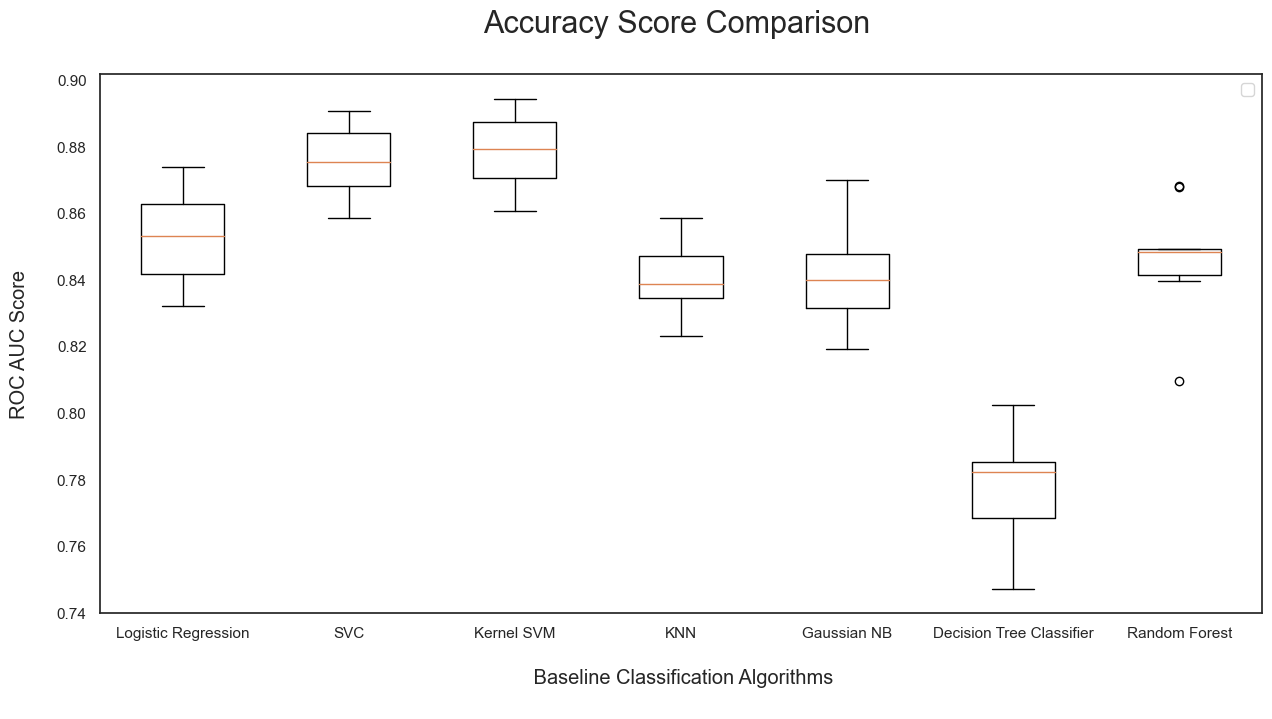

In [42]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)
plt.boxplot(acc_results)
ax.set_xticklabels(names)
plt.ylabel('ROC AUC Score\n',
horizontalalignment="center",fontstyle = "normal", 
fontsize = "large", fontfamily = "sans-serif")
plt.xlabel('\n Baseline Classification Algorithms\n',
horizontalalignment="center",fontstyle = "normal", 
fontsize = "large", fontfamily = "sans-serif")
plt.title('Accuracy Score Comparison \n',
horizontalalignment="center", fontstyle = "normal", 
fontsize = "22", fontfamily = "sans-serif")
plt.legend(loc='upper right', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


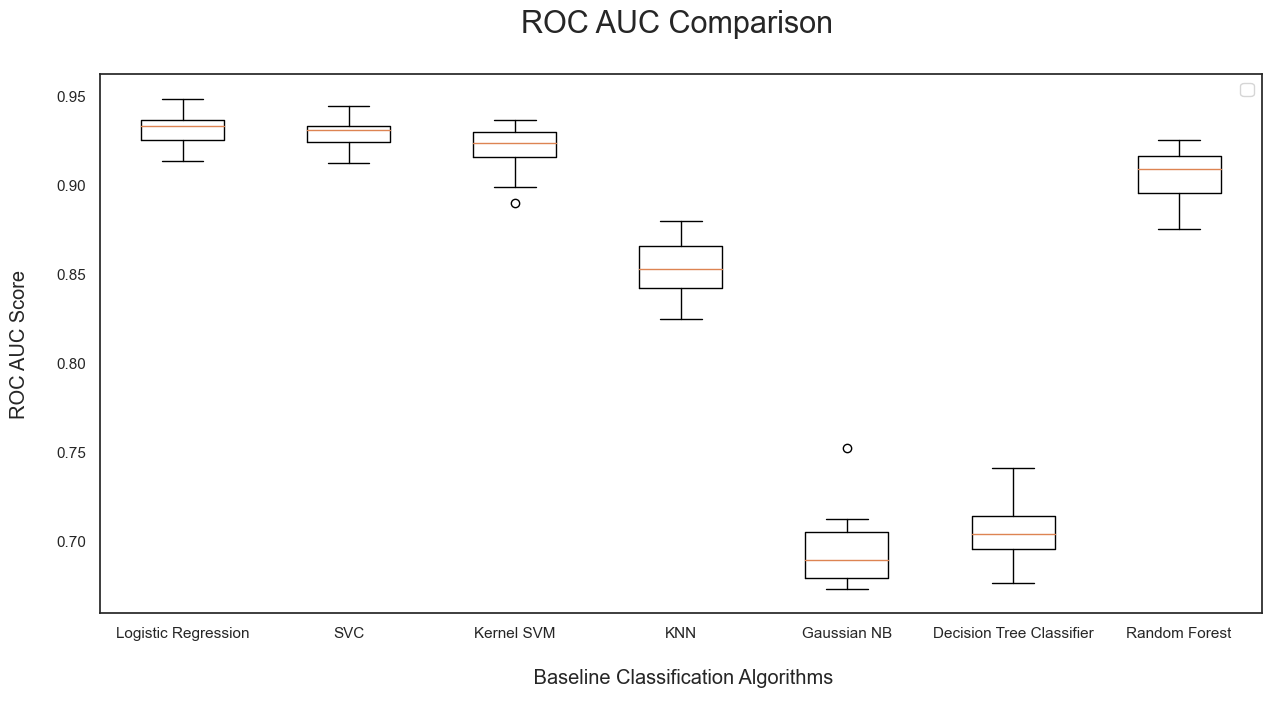

In [43]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)
plt.boxplot(auc_results)
ax.set_xticklabels(names)
plt.ylabel('ROC AUC Score\n',
horizontalalignment="center",fontstyle = "normal",
fontsize = "large", fontfamily = "sans-serif")
plt.xlabel('\n Baseline Classification Algorithms\n',
horizontalalignment="center",fontstyle = "normal", 
fontsize = "large", fontfamily = "sans-serif")
plt.title('ROC AUC Comparison \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", 
fontfamily = "sans-serif")
plt.legend(loc='upper right', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


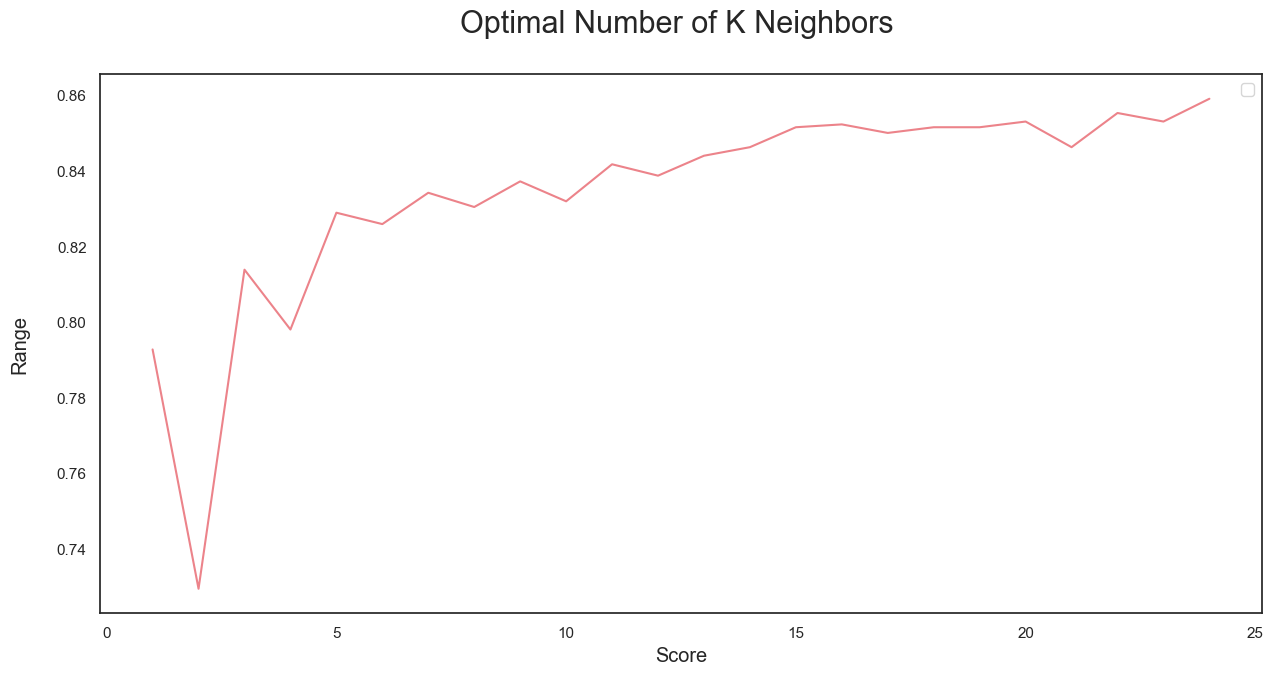

In [58]:
score_array = []
for each in range(1,25):
    knn_loop = KNeighborsClassifier(n_neighbors = each) 
    # set K neighbor as 3
    knn_loop.fit(X_train,y_train)
    score_array.append(knn_loop.score(X_test,y_test))
fig = plt.figure(figsize=(15, 7))
plt.plot(range(1,25),score_array, color = '#ec838a')
plt.ylabel('Range\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.xlabel('Score\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.title('Optimal Number of K Neighbors \n',
horizontalalignment="center", fontstyle = "normal",
 fontsize = "22", fontfamily = "sans-serif")
plt.legend(loc='upper right', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

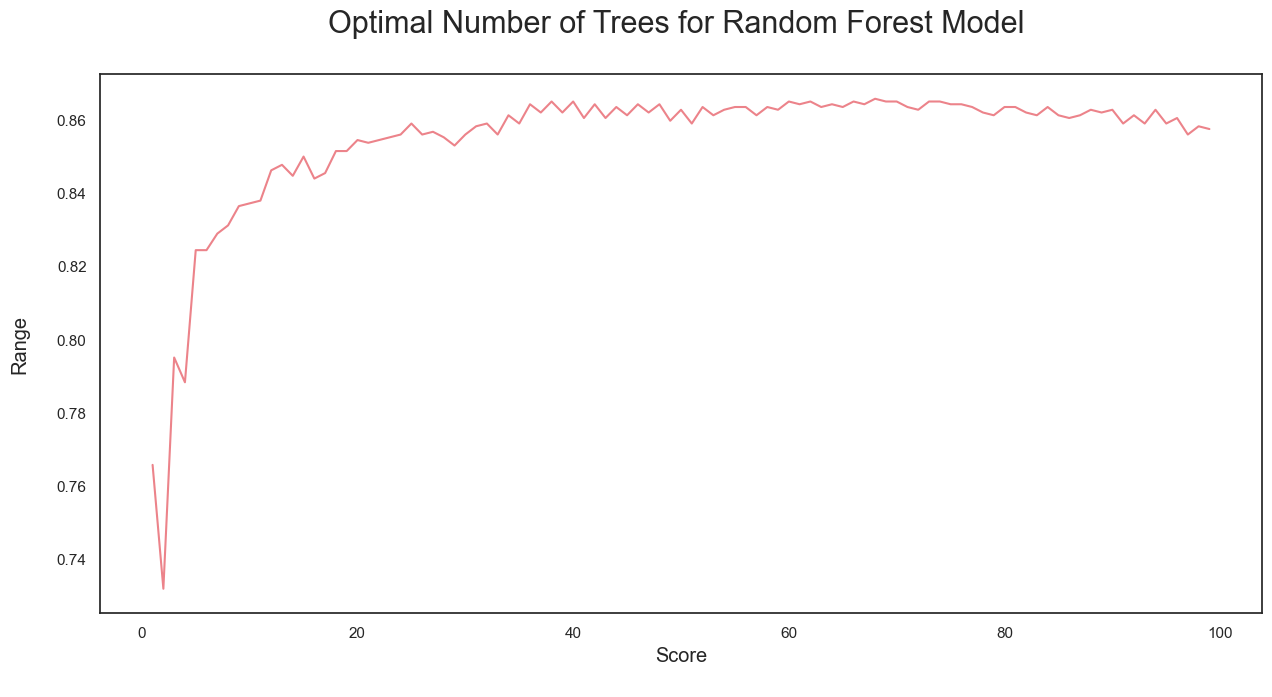

In [59]:
score_array = []
for each in range(1,100):
    rf_loop = RandomForestClassifier(
n_estimators = each, random_state = 1) 
    rf_loop.fit(X_train,y_train)
    score_array.append(rf_loop.score(X_test,y_test))
 
fig = plt.figure(figsize=(15, 7))
plt.plot(range(1,100),score_array, color = '#ec838a')
plt.ylabel('Range\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.xlabel('Score\n',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", 
fontfamily = "sans-serif")
plt.title('Optimal Number of Trees for Random Forest Model \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
#plt.legend(loc='top right', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

In [60]:
# Fitting Logistic Regression to the Training set
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)
# Predicting the Test set results
y_pred = classifier.predict(X_test)
# Evaluate results
acc = accuracy_score(y_test, y_pred )
prec = precision_score(y_test, y_pred )
rec = recall_score(y_test, y_pred )
f1 = f1_score(y_test, y_pred )
f2 = fbeta_score(y_test, y_pred, beta=2.0)
results = pd.DataFrame([['Logistic Regression', acc, prec, rec, f1, f2]], 
    columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score'])
results = results.sort_values(["Precision", "Recall", "F2 Score"], 
    ascending = False)
print (results)

                 Model  Accuracy  Precision    Recall  F1 Score  F2 Score
0  Logistic Regression  0.886963   0.902629  0.948823   0.92515   0.93921


In [61]:
# Fitting SVM (SVC class) to the Training set
classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(X_train, y_train)
# Predicting the Test set results y_pred = classifier.predict(X_test)
# Evaluate results
acc = accuracy_score(y_test, y_pred )
prec = precision_score(y_test, y_pred )
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred )
f2 = fbeta_score(y_test, y_pred, beta=2.0)
model_results = pd.DataFrame([['SVM (Linear)', acc, prec, rec, f1, f2]],
    columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score'])
results = results.append(model_results, ignore_index = True)
results = results.sort_values(["Precision", "Recall", "F2 Score"], 
    ascending = False)
print (results)

                 Model  Accuracy  Precision    Recall  F1 Score  F2 Score
0  Logistic Regression  0.886963   0.902629  0.948823   0.92515   0.93921
1         SVM (Linear)  0.886963   0.902629  0.948823   0.92515   0.93921


/var/folders/t6/t5h5090d6mb3hs8y3fgw7s8c0000gn/T/ipykernel_1558/3136711108.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(model_results, ignore_index = True)


In [62]:
# Fitting KNN to the Training set:
classifier = KNeighborsClassifier(
n_neighbors = 22, 
metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)
# Predicting the Test set results 
y_pred  = classifier.predict(X_test)
#Evaluate results
acc = accuracy_score(y_test, y_pred )
prec = precision_score(y_test, y_pred )
rec = recall_score(y_test, y_pred )
f1 = f1_score(y_test, y_pred )
f2 = fbeta_score(y_test, y_pred, beta=2.0)
model_results = pd.DataFrame([['K-Nearest Neighbours', acc, prec, rec, f1, f2]], 
    columns = ['Model','Accuracy', 'Precision', 'Recall','F1 Score', 'F2 Score'])
results = results.append(model_results, ignore_index = True)
results = results.sort_values(["Precision", "Recall", "F2 Score"], 
    ascending = False)
print (results)

                  Model  Accuracy  Precision    Recall  F1 Score  F2 Score
0   Logistic Regression  0.886963   0.902629  0.948823   0.92515  0.939210
1          SVM (Linear)  0.886963   0.902629  0.948823   0.92515  0.939210
2  K-Nearest Neighbours  0.855313   0.866480  0.949846   0.90625  0.931914


/var/folders/t6/t5h5090d6mb3hs8y3fgw7s8c0000gn/T/ipykernel_1558/1288064974.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(model_results, ignore_index = True)


In [63]:
# Fitting Kernel SVM to the Training set:
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train)
# Predicting the Test set results 
y_pred = classifier.predict(X_test)
#Evaluate results
acc = accuracy_score(y_test, y_pred )
prec = precision_score(y_test, y_pred )
rec = recall_score(y_test, y_pred )
f1 = f1_score(y_test, y_pred )
f2 = fbeta_score(y_test, y_pred, beta=2.0)
model_results = pd.DataFrame([['Kernel SVM', acc, prec, rec, f1, f2]],
    columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score'])
results = results.append(model_results, ignore_index = True)
results = results.sort_values(["Precision", "Recall", "F2 Score"], 
    ascending = False)
print (results)

                  Model  Accuracy  Precision    Recall  F1 Score  F2 Score
0   Logistic Regression  0.886963   0.902629  0.948823  0.925150  0.939210
1          SVM (Linear)  0.886963   0.902629  0.948823  0.925150  0.939210
3            Kernel SVM  0.880934   0.885230  0.963153  0.922549  0.946490
2  K-Nearest Neighbours  0.855313   0.866480  0.949846  0.906250  0.931914


/var/folders/t6/t5h5090d6mb3hs8y3fgw7s8c0000gn/T/ipykernel_1558/1996493497.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(model_results, ignore_index = True)


In [64]:
# Fitting Naive Byes to the Training set:
classifier = GaussianNB()
classifier.fit(X_train, y_train)
# Predicting the Test set results 
y_pred = classifier.predict(X_test)
#Evaluate results
acc = accuracy_score(y_test, y_pred )
prec = precision_score(y_test, y_pred )
rec = recall_score(y_test, y_pred )
f1 = f1_score(y_test, y_pred )
f2 = fbeta_score(y_test, y_pred, beta=2.0)
model_results = pd.DataFrame([['Naive Byes', acc, prec, rec, f1, f2]],
    columns = ['Model', 'Accuracy', 'Precision','Recall', 'F1 Score', 'F2 Score'])
results = results.append(model_results, ignore_index = True)
results = results.sort_values(["Precision", "Recall", "F2 Score"], ascending = False)
print (results)

                  Model  Accuracy  Precision    Recall  F1 Score  F2 Score
0   Logistic Regression  0.886963   0.902629  0.948823  0.925150  0.939210
1          SVM (Linear)  0.886963   0.902629  0.948823  0.925150  0.939210
2            Kernel SVM  0.880934   0.885230  0.963153  0.922549  0.946490
3  K-Nearest Neighbours  0.855313   0.866480  0.949846  0.906250  0.931914
4            Naive Byes  0.840241   0.821699  1.000000  0.902124  0.958407


/var/folders/t6/t5h5090d6mb3hs8y3fgw7s8c0000gn/T/ipykernel_1558/2132276753.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(model_results, ignore_index = True)


In [65]:
# Fitting Decision Tree to the Training set:
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)
# Predicting the Test set results 
y_pred = classifier.predict(X_test)
#Evaluate results
acc = accuracy_score(y_test, y_pred )
prec = precision_score(y_test, y_pred )
rec = recall_score(y_test, y_pred )
f1 = f1_score(y_test, y_pred )
f2 = fbeta_score(y_test, y_pred, beta=2.0)
model_results = pd.DataFrame([['Decision Tree', acc, prec, rec, f1, f2]],
    columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score'])
results = results.append(model_results, ignore_index = True)
results = results.sort_values(["Precision", "Recall", "F2 Score"], ascending = False)
print (results)

                  Model  Accuracy  Precision    Recall  F1 Score  F2 Score
0   Logistic Regression  0.886963   0.902629  0.948823  0.925150  0.939210
1          SVM (Linear)  0.886963   0.902629  0.948823  0.925150  0.939210
2            Kernel SVM  0.880934   0.885230  0.963153  0.922549  0.946490
3  K-Nearest Neighbours  0.855313   0.866480  0.949846  0.906250  0.931914
5         Decision Tree  0.791258   0.861570  0.853634  0.857584  0.855209
4            Naive Byes  0.840241   0.821699  1.000000  0.902124  0.958407


/var/folders/t6/t5h5090d6mb3hs8y3fgw7s8c0000gn/T/ipykernel_1558/3362002172.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(model_results, ignore_index = True)


In [66]:
# Fitting Random Forest to the Training set:
    
classifier = RandomForestClassifier(n_estimators = 72, 
criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)
# Predicting the Test set results 
y_pred = classifier.predict(X_test)
# Evaluate results
accuracy_score, f1_score, precision_score, recall_score
acc = accuracy_score(y_test, y_pred )
prec = precision_score(y_test, y_pred )
rec = recall_score(y_test, y_pred )
f1 = f1_score(y_test, y_pred )
f2 = fbeta_score(y_test, y_pred, beta=2.0)
model_results = pd.DataFrame([['Random Forest', acc, prec, rec, f1, f2]],
    columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score'])
results = results.append(model_results, ignore_index = True)
results = results.sort_values(["Precision", "Recall", "F2 Score"], ascending = False)
print (results)

                  Model  Accuracy  Precision    Recall  F1 Score  F2 Score
0   Logistic Regression  0.886963   0.902629  0.948823  0.925150  0.939210
1          SVM (Linear)  0.886963   0.902629  0.948823  0.925150  0.939210
2            Kernel SVM  0.880934   0.885230  0.963153  0.922549  0.946490
6         Random Forest  0.848531   0.867424  0.937564  0.901131  0.922643
3  K-Nearest Neighbours  0.855313   0.866480  0.949846  0.906250  0.931914
4         Decision Tree  0.791258   0.861570  0.853634  0.857584  0.855209
5            Naive Byes  0.840241   0.821699  1.000000  0.902124  0.958407


/var/folders/t6/t5h5090d6mb3hs8y3fgw7s8c0000gn/T/ipykernel_1558/1100901335.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(model_results, ignore_index = True)


In [67]:
classifier = LogisticRegression(random_state = 0,
penalty = 'l2')
classifier.fit(X_train, y_train)
# Predict the Test set results
y_pred = classifier.predict(X_test)
#Evaluate Model Results on Test Set:
acc = accuracy_score(y_test, y_pred )
prec = precision_score(y_test, y_pred )
rec = recall_score(y_test, y_pred )
f1 = f1_score(y_test, y_pred )
f2 = fbeta_score(y_test, y_pred, beta=2.0)
results = pd.DataFrame([['Logistic Regression',
acc, prec, rec, f1, f2]],columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score'])
print (results)

                 Model  Accuracy  Precision    Recall  F1 Score  F2 Score
0  Logistic Regression  0.886963   0.902629  0.948823   0.92515   0.93921


In [68]:
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Logistic Regression Classifier Accuracy: %0.2f (+/- %0.2f)"  % (accuracies.mean(), accuracies.std() * 2))

Logistic Regression Classifier Accuracy: 0.88 (+/- 0.02)


Text(0.5, 20.049999999999997, 'Predicted label\n')

<Figure size 2800x2000 with 0 Axes>

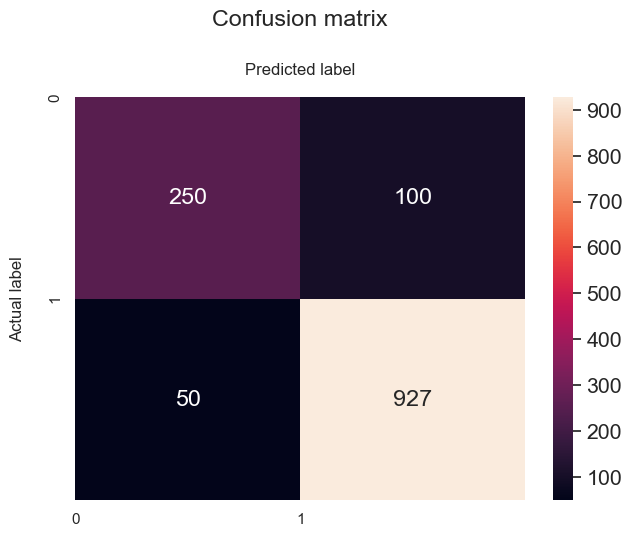

In [69]:
cm = confusion_matrix(y_test, y_pred) 
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (28,20))
fig, ax = plt.subplots()
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g')
class_names=[0,1]
tick_marks = np.arange(len(class_names))
plt.tight_layout()
plt.title('Confusion matrix\n', y=1.1)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
ax.xaxis.set_label_position("top")
plt.ylabel('Actual label\n')
plt.xlabel('Predicted label\n')

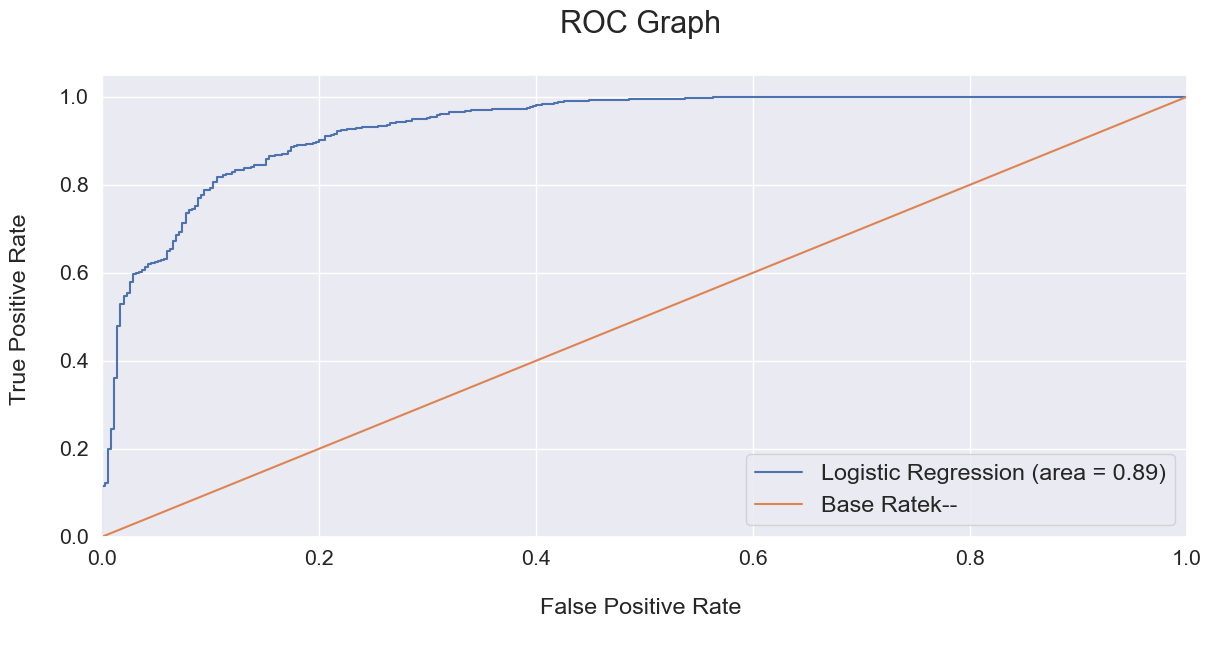

In [70]:
classifier.fit(X_train, y_train) 
probs = classifier.predict_proba(X_test) 
probs = probs[:, 1] 
classifier_roc_auc = accuracy_score(y_test, y_pred )
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
plt.figure(figsize=(14, 6))
# Plot Logistic Regression ROC
plt.plot(rf_fpr, rf_tpr, 
label='Logistic Regression (area = %0.2f)' % classifier_roc_auc)
# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('True Positive Rate \n',horizontalalignment="center",
fontstyle = "normal", fontsize = "medium", 
fontfamily = "sans-serif")
plt.xlabel('\nFalse Positive Rate \n',horizontalalignment="center",
fontstyle = "normal", fontsize = "medium", 
fontfamily = "sans-serif")
plt.title('ROC Graph \n',horizontalalignment="center", 
fontstyle = "normal", fontsize = "22", 
fontfamily = "sans-serif")
plt.legend(loc="lower right", fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

In [81]:
# Analyzing Coefficients
feature_importances = pd.concat([
pd.DataFrame(dataset.columns, columns = ["features"]),
pd.DataFrame(np.transpose(classifier.coef_), 
columns = ["coef"])],axis = 1)
feature_importances.sort_values("coef", ascending = False).head(10)

,features,coef
4,anciennete_mois,1.330627
20,var_0,0.869343
19,age,0.845492
7,cartes_bancaires,0.636261
35,var_15,0.330829
32,var_12,0.307367
13,credit_immo,0.294907
49,var_29,0.291472
14,type,0.291147
50,var_30,0.253511


In [72]:
# Round 1:
 
# Select Regularization Method   
import time
penalty = ['l1', 'l2']
# Create regularization hyperparameter space
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
# Combine Parameters
parameters = dict(C=C, penalty=penalty)
lr_classifier = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = "balanced_accuracy",
                           cv = 10,
                           n_jobs = -1)
t0 = time.time()
lr_classifier  = lr_classifier .fit(X_train, y_train)
t1 = time.time()
print("Took %0.2f seconds" % (t1 - t0))
lr_best_accuracy = lr_classifier.best_score_
lr_best_parameters = lr_classifier.best_params_
lr_best_accuracy, lr_best_parameters

/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Took 1.50 seconds


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
70 fits failed out of a total of 140.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:


(0.8181738872975142, {'C': 1, 'penalty': 'l2'})

In [73]:
# Round 2:
# Select Regularization Method
import time
penalty = ['l2']
# Create regularization hyperparameter space
C = [ 0.0001, 0.001, 0.01, 0.02, 0.05]
# Combine Parameters
parameters = dict(C=C, penalty=penalty)
lr_classifier = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = "balanced_accuracy",
                           cv = 10,
                           n_jobs = -1)
t0 = time.time()
lr_classifier  = lr_classifier .fit(X_train, y_train)
t1 = time.time()
print("Took %0.2f seconds" % (t1 - t0))
lr_best_accuracy = lr_classifier.best_score_
lr_best_parameters = lr_classifier.best_params_
lr_best_accuracy, lr_best_parameters

Took 0.37 seconds


(0.8178658949684635, {'C': 0.05, 'penalty': 'l2'})

In [74]:
lr_classifier = LogisticRegression(random_state = 0, penalty = 'l2')
lr_classifier.fit(X_train, y_train)
# Predict the Test set results
y_pred = lr_classifier.predict(X_test)
#probability score
y_pred_probs = lr_classifier.predict_proba(X_test)
y_pred_probs  = y_pred_probs [:, 1]

[[250 100]
 [ 50 927]]
Test Data Accuracy: 0.8870


<Figure size 2800x2000 with 0 Axes>

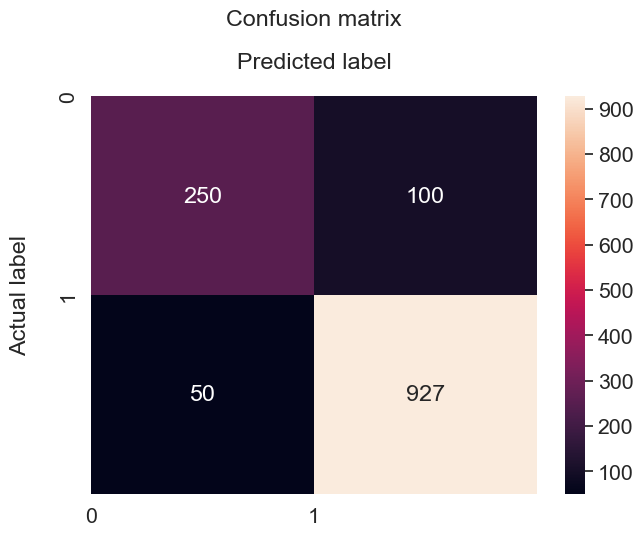

In [75]:
#Revalidate final results with Confusion Matrix:
cm = confusion_matrix(y_test, y_pred) 
print (cm)
#Confusion Matrix as a quick Crosstab:
    
pd.crosstab(y_test,pd.Series(y_pred),
rownames=['ACTUAL'],colnames=['PRED'])
#visualize Confusion Matrix:
cm = confusion_matrix(y_test, y_pred) 
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (28,20))
fig, ax = plt.subplots()
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g'#,cmap="YlGnBu" 
           )
class_names=[0,1]
tick_marks = np.arange(len(class_names))
plt.tight_layout()
plt.title('Confusion matrix\n', y=1.1)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
ax.xaxis.set_label_position("top")
plt.ylabel('Actual label\n')
plt.xlabel('Predicted label\n')
print("Test Data Accuracy: %0.4f" % accuracy_score(y_test, y_pred))

In [79]:
final_results = pd.concat([ y_test], axis = 1).dropna()
final_results['predictions'] = y_pred
final_results["propensity_to_churn(%)"] = y_pred_probs
final_results["propensity_to_churn(%)"] = final_results["propensity_to_churn(%)"]*100
final_results["propensity_to_churn(%)"]=final_results["propensity_to_churn(%)"].round(2)
final_results = final_results[['churn', 'predictions', 'propensity_to_churn(%)']]
final_results ['Ranking'] = pd.qcut(final_results['propensity_to_churn(%)'].rank(method = 'first'),10,labels=range(10,0,-1))
print (final_results)

           churn  predictions  propensity_to_churn(%) Ranking
id_client                                                    
454            1            1                   99.90       1
1493           1            0                   35.13       9
3866           1            1                   89.77       6
4485           1            1                  100.00       1
4639           1            1                   96.89       4
...          ...          ...                     ...     ...
5458           0            0                    0.03      10
1358           1            1                   92.85       5
885            1            1                   73.21       7
5569           0            0                   18.85       9
5087           1            1                   98.64       3

[1327 rows x 4 columns]


In [77]:
import joblib

filename = 'final_model.model'
i = [lr_classifier]
joblib.dump(i,filename)

['final_model.model']